In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

species  elevation       landcovertype  vegetationindex  presence
0  Apus apus        2.0               Water         0.000000         0
1  Apus apus        3.0               Grass         0.511561         0
2  Apus apus       39.0               Grass         0.670993         0
3  Apus apus        1.0               Grass         0.511561         0
4  Apus apus        0.0  Flooded_Vegetation         0.000000         0

In [4]:
# data.species.value_counts()
# data.vegetationindex.value_counts()

## 1.0  Missing Value

In [5]:
# Check for missing values
data.isnull().sum()


species            0
elevation          3
landcovertype      4
vegetationindex    4
presence           0
dtype: int64

In [6]:
# Show rows with missing values
data[data.isnull().any(axis=1)]

species  elevation landcovertype  vegetationindex  presence
6043   Apus apus        NaN         Built         0.000000         0
7166   Apus apus       37.0         Grass              NaN         0
7168   Apus apus       37.0         Grass              NaN         0
7800   Apus apus       74.0           NaN         0.513397         0
8911   Apus apus        NaN         Trees         0.439200         0
11876  Apus apus      113.0         Trees              NaN         0
11942  Apus apus      142.0           NaN         0.477375         1
14887  Apus apus       38.0           NaN         0.362805         0
14923  Apus apus       60.0           NaN         0.440965         0
15168  Apus apus      176.0         Trees              NaN         0
15200  Apus apus        NaN         Trees         0.624900         0

It was discovered that some columns has missing values however, we will be filling those missing values with median and mode.

In [7]:
# Fill missing values for 'elevation' using the median
data['elevation'] = data['elevation'].fillna(data['elevation'].median())


data['vegetationindex'] = data['vegetationindex'].fillna(data['vegetationindex'].median())


data['landcovertype'] = data['landcovertype'].fillna(data['landcovertype'].mode()[0])

print(data.isnull().sum())

species            0
elevation          0
landcovertype      0
vegetationindex    0
presence           0
dtype: int64


The reason we focused on making use of median for the data imputation was beacuse we didnt want to affect the skewness of the data. Using mean might draw the outlier to itself which makes it skew to the outlier value

## 2.0 Outlier Detection

In [8]:
data.describe()

elevation  vegetationindex      presence
count  16643.000000     16643.000000  16643.000000
mean      95.614913         0.309769      0.055699
std       62.715929         0.214440      0.229347
min       -2.000000         0.000000      0.000000
25%       44.000000         0.000000      0.000000
50%      111.000000         0.324444      0.000000
75%      113.000000         0.472957      0.000000
max      732.000000         0.801485      1.000000

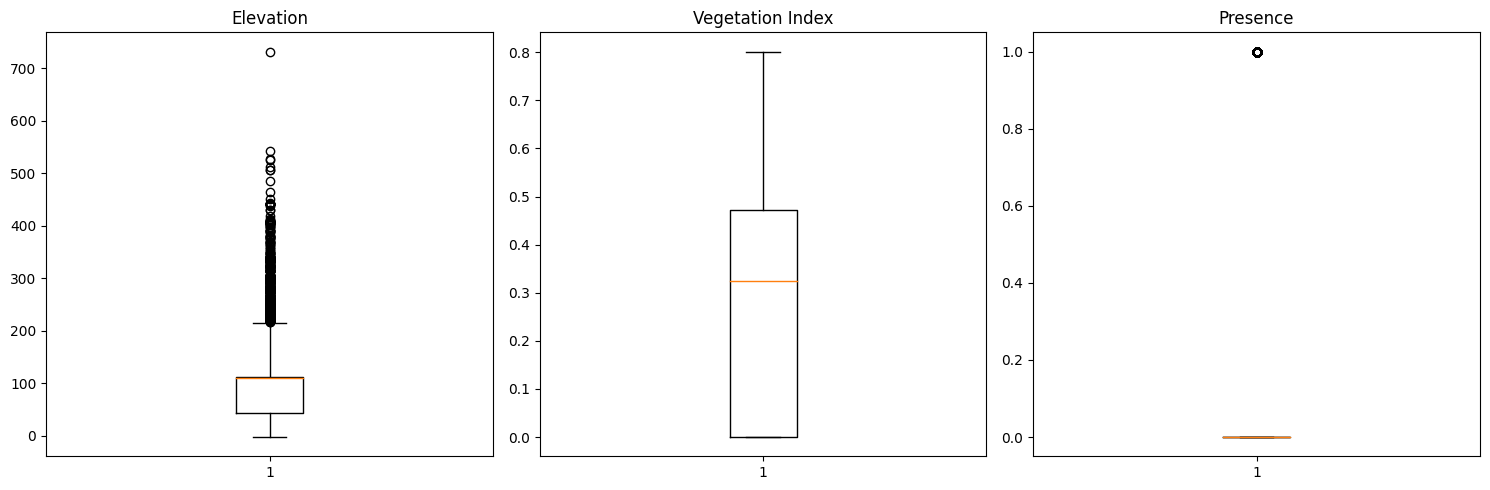

In [9]:
import matplotlib.pyplot as plt

data_to_plot = [data['elevation'], data['vegetationindex'], data['presence']]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.boxplot(data_to_plot[0])

plt.title('Elevation')
plt.subplot(1, 3, 2)
plt.boxplot(data_to_plot[1])
plt.title('Vegetation Index')

plt.subplot(1, 3, 3)
plt.boxplot(data_to_plot[2])
plt.title('Presence')

plt.tight_layout()
plt.show()


1. Based on the boxplot I can observe that `elevation` shows a significant number of outliers on the higher end which shows that several data points lies above the range of 200, with the highest outlier nearing 700. This means that most `elevation`values are within the lower range (200) however, there is a significant amount of `elevation` that deviate from the median.

2. `Vegetation Index` values shows some outlier that is slightly above 0.8 which means that most `vegetation index` values are concentrated below 0.8 with few values above 0.8 which are outliers.

3. Presence is just a a binary class data with no outliers.




Based on our observation on the boxplot, it was obvious that there exist some. outliers on two major varriables in the dataset.

We will therefore conduct outlier detection and removal based on the interqualtile range of the data

In [10]:
# Detect and remove outliers in 'elevation'
Q1_elevation = data['elevation'].quantile(0.25)
Q3_elevation = data['elevation'].quantile(0.75)
IQR_elevation = Q3_elevation - Q1_elevation

lower_bound_elevation = Q1_elevation - 1.5 * IQR_elevation
upper_bound_elevation = Q3_elevation + 1.5 * IQR_elevation

# Filter to keep only non-outliers in 'elevation'
non_outliers_elevation = data[(data['elevation'] >= lower_bound_elevation) & (data['elevation'] <= upper_bound_elevation)]

print(non_outliers_elevation.describe())
data = non_outliers_elevation


          elevation  vegetationindex      presence
count  16018.000000     16018.000000  16018.000000
mean      88.013797         0.308356      0.054688
std       48.942510         0.214960      0.227378
min       -2.000000         0.000000      0.000000
25%       43.000000         0.000000      0.000000
50%      111.000000         0.324444      0.000000
75%      113.000000         0.471004      0.000000
max      216.000000         0.801485      1.000000


In [11]:
# Detect and remove outliers in 'vegetationindex'
Q1_vegetationindex = data['vegetationindex'].quantile(0.25)
Q3_vegetationindex = data['vegetationindex'].quantile(0.75)
IQR_vegetationindex = Q3_vegetationindex - Q1_vegetationindex

lower_bound_vegetationindex = Q1_vegetationindex - 1.5 * IQR_vegetationindex
upper_bound_vegetationindex = Q3_vegetationindex + 1.5 * IQR_vegetationindex

# Filter to keep only non-outliers in 'vegetationindex'
non_outliers_vegetationindex = data[(data['vegetationindex'] >= lower_bound_vegetationindex) & (data['vegetationindex'] <= upper_bound_vegetationindex)]

print(non_outliers_vegetationindex.describe())

data = non_outliers_vegetationindex


          elevation  vegetationindex      presence
count  16018.000000     16018.000000  16018.000000
mean      88.013797         0.308356      0.054688
std       48.942510         0.214960      0.227378
min       -2.000000         0.000000      0.000000
25%       43.000000         0.000000      0.000000
50%      111.000000         0.324444      0.000000
75%      113.000000         0.471004      0.000000
max      216.000000         0.801485      1.000000


## 3.0 Feature Engineering

### 3.1 Distribution of Land Cover Type

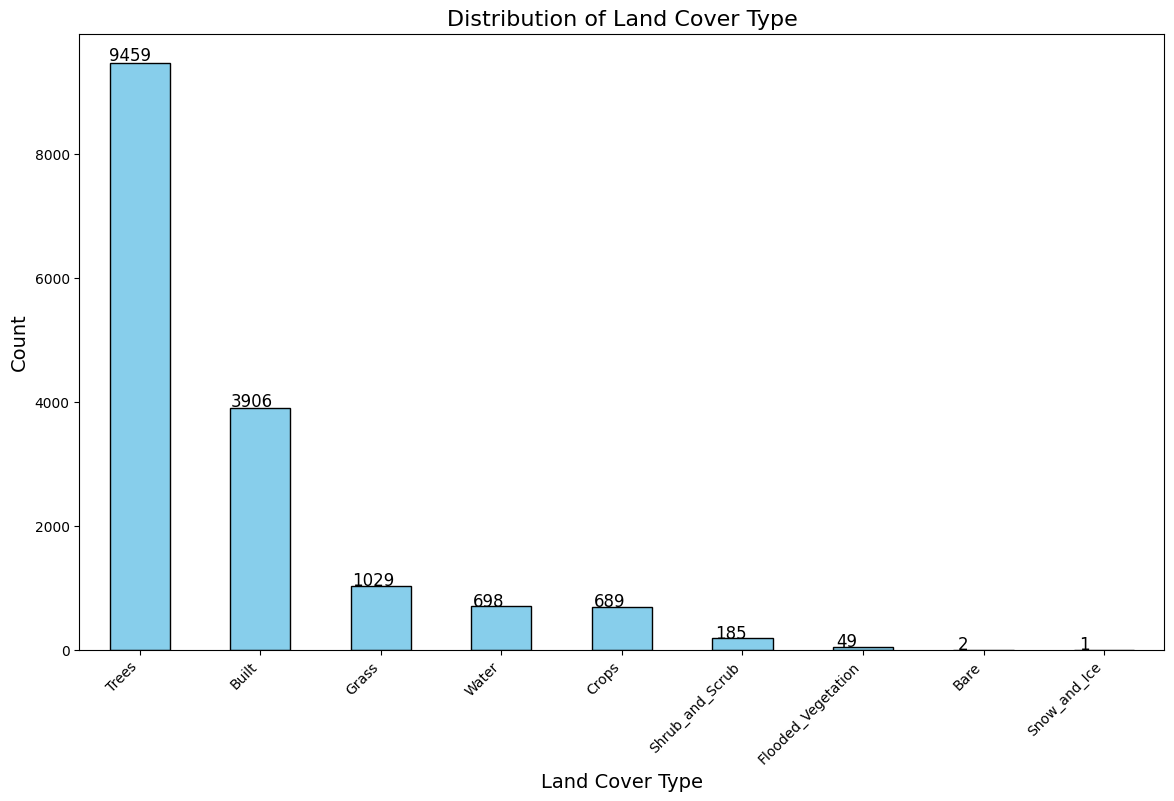

In [12]:
# Plotting landcovertype
plt.figure(figsize=(14, 8))
landcovertype_counts = data['landcovertype'].value_counts()
ax = landcovertype_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Land Cover Type', fontsize=16)
plt.xlabel('Land Cover Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Adding data labels
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() * 1.005, i.get_height() * 1.005), fontsize=12, color='black')

plt.show()

### 3.2 Distribution of Presence

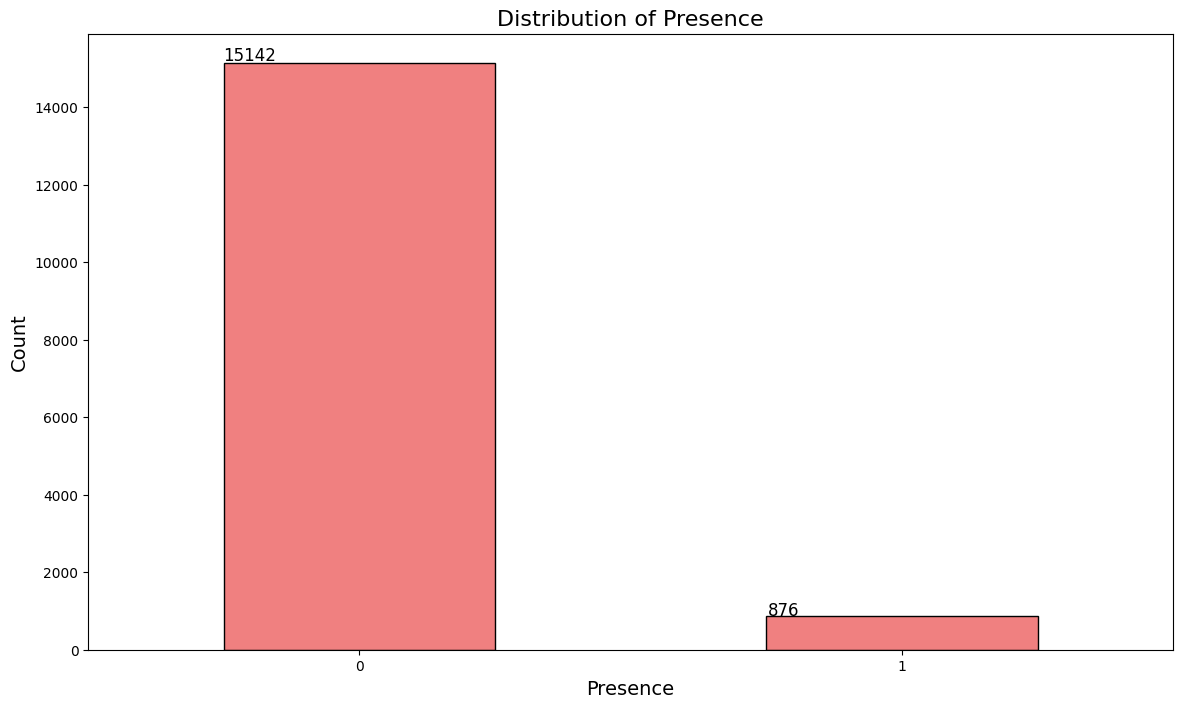

In [13]:
# Plotting presence
plt.figure(figsize=(14, 8))
presence_counts = data['presence'].value_counts()
ax = presence_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Distribution of Presence', fontsize=16)
plt.xlabel('Presence', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)

# Adding data labels
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() * 1.005, i.get_height() * 1.005), fontsize=12, color='black')

plt.show()

In [14]:
# Label encoding for 'landcovertype'
label_encoder = LabelEncoder()
data['landcovertype'] = label_encoder.fit_transform(data['landcovertype'])


### 3.3 More Feature engineering

In [15]:
# Creating interaction features
data['elevation_vegetationindex'] = data['elevation'] * data['vegetationindex']
data.head()


species  elevation  landcovertype  vegetationindex  presence  \
0  Apus apus        2.0              8         0.000000         0   
1  Apus apus        3.0              4         0.511561         0   
2  Apus apus       39.0              4         0.670993         0   
3  Apus apus        1.0              4         0.511561         0   
4  Apus apus        0.0              3         0.000000         0   

   elevation_vegetationindex  
0                   0.000000  
1                   1.534682  
2                  26.168739  
3                   0.511561  
4                   0.000000

### 3.4 Standardizing numerical features

In [16]:
scaler = StandardScaler()
numerical_features = ['elevation', 'vegetationindex', 'elevation_vegetationindex']
data[numerical_features] = scaler.fit_transform(data[numerical_features])


### 3.5 Correlation Heatmap

In [17]:
data = data.drop('species', axis=1)

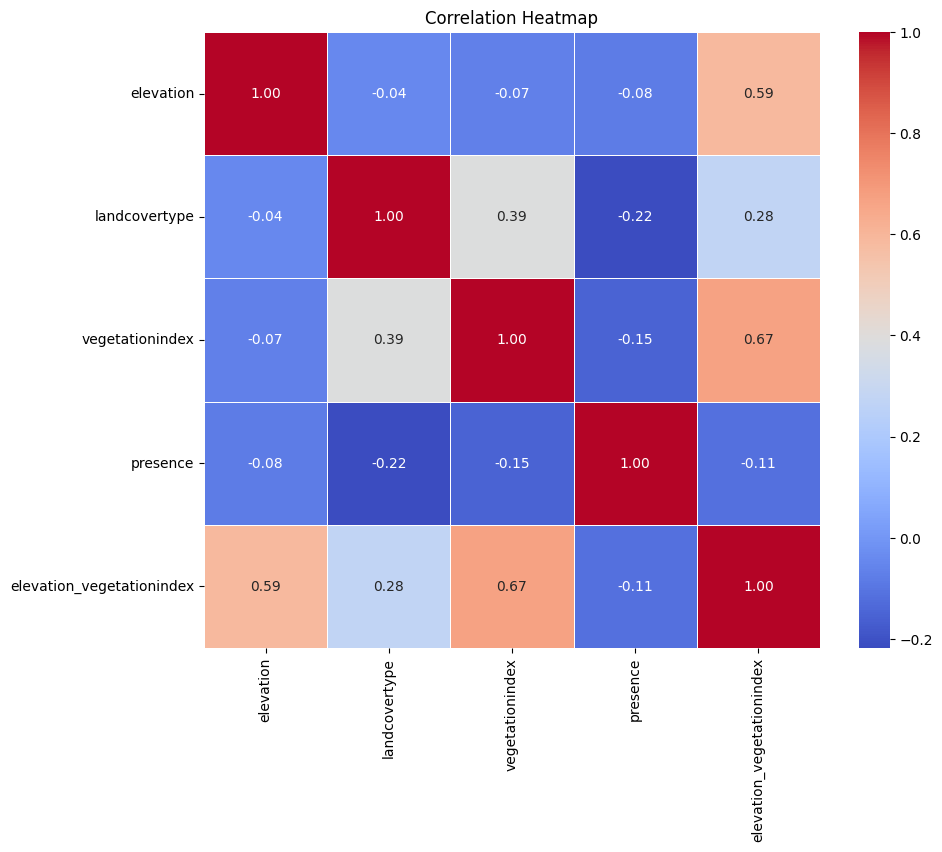

In [18]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Based on the heatmap, we can see that none of the features have a strong correlation with presence, which suggests that simple linear relationships might not be enough to predict the target variable. However, we'll still keep this in mind as a preliminary step

`Landcovertype` is the most relevant feature for predicting the target variable presence, even though its correlation is negative and weak. `Vegetation Index` and `Elevation_VegetationIndex` also have some relevance but are less negative correlated with the target variable compared to `Landcovertype`. `Elevation` appears to be the least relevant feature based on its correlation with presence.

## 4.0 Model Training and Performance Evaluation:

### 4.1 Imbalance Data

### 4.2 Distribution of Target Variable

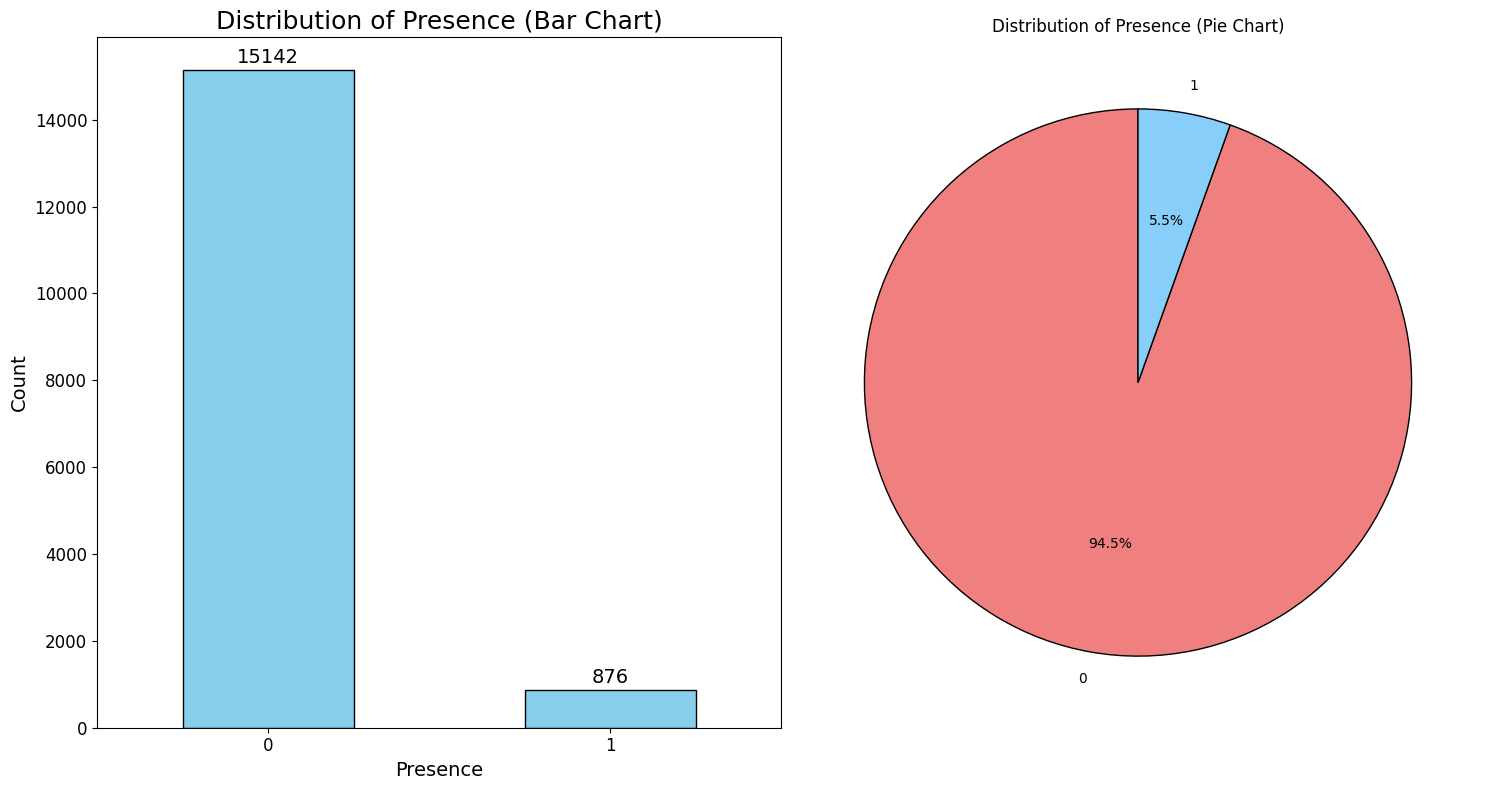

In [19]:
plt.figure(figsize=(15, 8))
# bar chart
plt.subplot(1, 2, 1)
presence_counts = data['presence'].value_counts()
ax = presence_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Presence (Bar Chart)', fontsize=18)
plt.xlabel('Presence', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add value counts on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 5), textcoords='offset points')


# Pie chart
plt.subplot(1, 2, 2)
presence_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Presence (Pie Chart)')
plt.ylabel('')  # Hide y-label for the pie chart

plt.tight_layout()
plt.show()

The chart above shows the distribution of the target variable which shows that the data is highly class imbalance of ratio 95:5. Therefore we will explore the use of data sampling techniques to augument the data.

Ideally, we can either undersampling the majority class or oversample the minority class. However, judging by the value counts of the minority class (876), we might end up loosing up to 95% of our dataset if we decide to undersample the majority class.

Therefore, in the case of this task, we will priortize the use of oversampling method where we will explore the use of some oversampling methods.

We will therefore experiment on:

- Synthetic Minority Over-sampling (SMOTE)

- Adaptive Synthetic Sampling (ADASYN)

- Borderline-SMOTE

- Support Vector Machine SMOTE (SVM-SMOTE)

Also we will be working on building this pipeline with a tree based models listed below:

- Random Forest

- Gradient Boosting Algorithm

- Adaboost

Tree-based models like Random Forests and Gradient Boosting are inherently good in handling imbalanced datasets because they can handle complex decision boundaries and are less likely to be influenced by the majority class.

However, exploring resampling methods is also crucial to ensure the best model performance.

In [20]:
X = data.drop('presence', axis=1)
y = data['presence']

In [21]:
print(f'Shape of the original features: {X.shape}')
print(f'Shape of the original target variable: {y.shape}')


Shape of the original features: (16018, 4)
Shape of the original target variable: (16018,)


In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
print(f'Shape of the training features: {X_train.shape}')
print(f'Shape of the testing features: {X_test.shape}')
print(f'Shape of the training target variable: {y_train.shape}')
print(f'Shape of the testing target variable: {y_test.shape}')

Shape of the training features: (12814, 4)
Shape of the testing features: (3204, 4)
Shape of the training target variable: (12814,)
Shape of the testing target variable: (3204,)


### 4.3 Model Selection and Hyperparameters

It has been established that tree based model are better when it comes to handling of imbalance data. However, based on the corrrelation heatmap, it was obvious that the features are not positively correlated with the target variable. This means that a basic model that solve linearity problem will not perform well in the modelling phase. Therefore, it will be better to select better models that can solve complex problems and more complex interactions in the data.

In terms of the hyperparameters, we underrstand the fact that we have to find the best hyperparameters for each of the models at every stage. Therefore, we decided to create a parameter-grid (`space of hyper-parameters`) and use a grid-search crossvalidation method to select the best hyperparrameter for now.

In [24]:
# Define models and hyperparameters
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

In [25]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'AdaBoost': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1, 1]
    }
}

### 4.4 Train Without Resampling

In [26]:
cv_results = []
best_models = {}

for model_name, model in tqdm(models.items()):
    print(f"\nPerforming Grid Search for {model_name}...")

    pipeline = Pipeline([
        ('classifier', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    mean_cv_score = grid_search.best_score_
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f"{model_name} Best CV F1 Score: {mean_cv_score:.4f}")
    print(f"{model_name} Best Hyperparameters: {best_params}")

    # Store the best model
    best_models[model_name] = best_model

    cv_results.append({
        'Model': model_name,
        'Best CV F1 Score': mean_cv_score,
        'Best Hyperparameters': best_params
    })

  0%|          | 0/3 [00:00<?, ?it/s]


Performing Grid Search for RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [03:03<06:06, 183.13s/it]

RandomForest Best CV F1 Score: 0.8122
RandomForest Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Performing Grid Search for GradientBoosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 67%|██████▋   | 2/3 [06:48<03:27, 207.84s/it]

GradientBoosting Best CV F1 Score: 0.8101
GradientBoosting Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}

Performing Grid Search for AdaBoost...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 3/3 [07:07<00:00, 142.65s/it]

AdaBoost Best CV F1 Score: 0.3683
AdaBoost Best Hyperparameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}


In [27]:
# Create a summary table for best CV score and best hyperparameters for each model
summary_table = pd.DataFrame(cv_results)
print("\nSummary Table:")
summary_table.head()


Summary Table:


Model  Best CV F1 Score  \
0      RandomForest          0.812175   
1  GradientBoosting          0.810097   
2          AdaBoost          0.368273   

                                Best Hyperparameters  
0  {'classifier__max_depth': 20, 'classifier__min...  
1  {'classifier__learning_rate': 0.1, 'classifier...  
2  {'classifier__learning_rate': 1, 'classifier__...


Evaluating RandomForest...

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3029
           1       0.85      0.73      0.79       175

    accuracy                           0.98      3204
   macro avg       0.92      0.86      0.89      3204
weighted avg       0.98      0.98      0.98      3204

ROC AUC: 0.95
Confusion Matrix:
[[3007   22]
 [  47  128]]


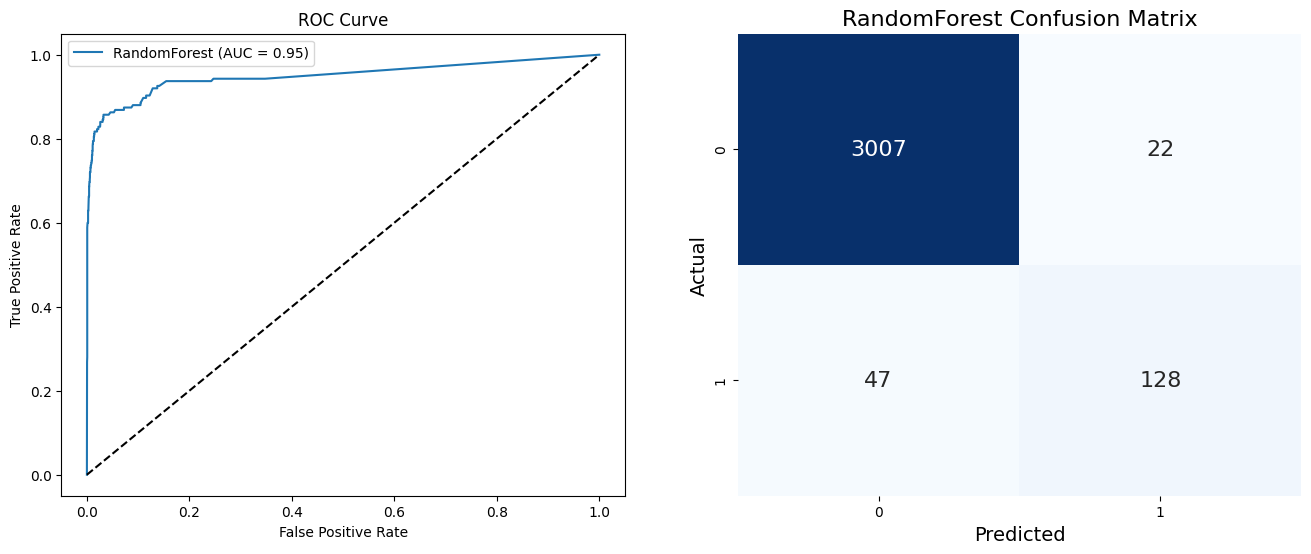


Evaluating GradientBoosting...

GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3029
           1       0.83      0.74      0.79       175

    accuracy                           0.98      3204
   macro avg       0.91      0.87      0.89      3204
weighted avg       0.98      0.98      0.98      3204

ROC AUC: 0.95
Confusion Matrix:
[[3003   26]
 [  45  130]]


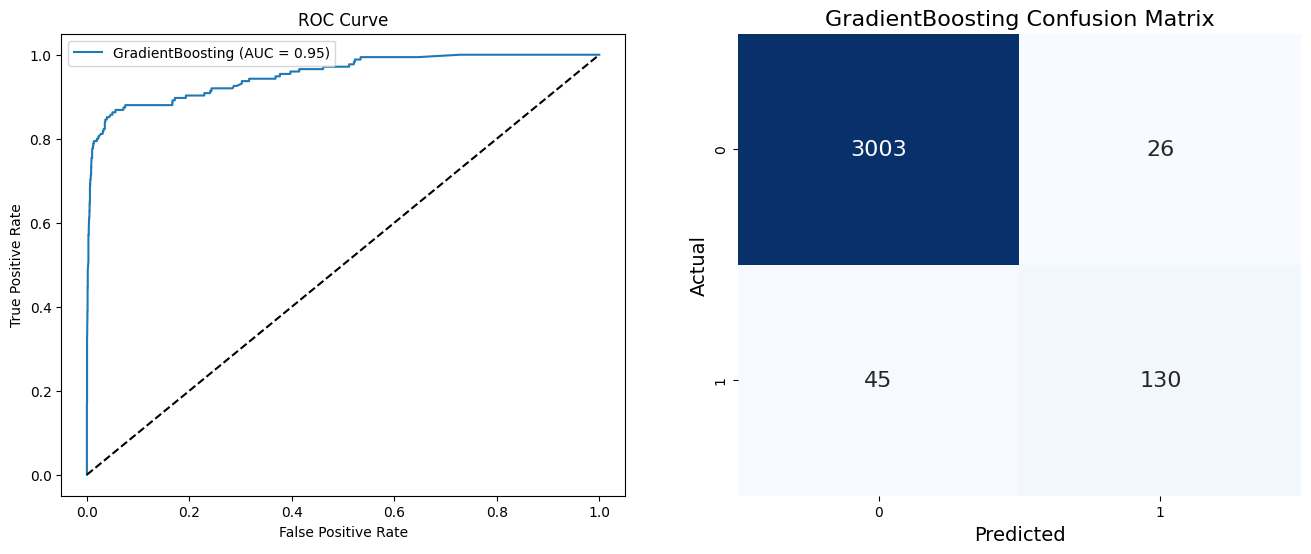


Evaluating AdaBoost...

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3029
           1       0.81      0.29      0.42       175

    accuracy                           0.96      3204
   macro avg       0.88      0.64      0.70      3204
weighted avg       0.95      0.96      0.95      3204

ROC AUC: 0.93
Confusion Matrix:
[[3017   12]
 [ 125   50]]


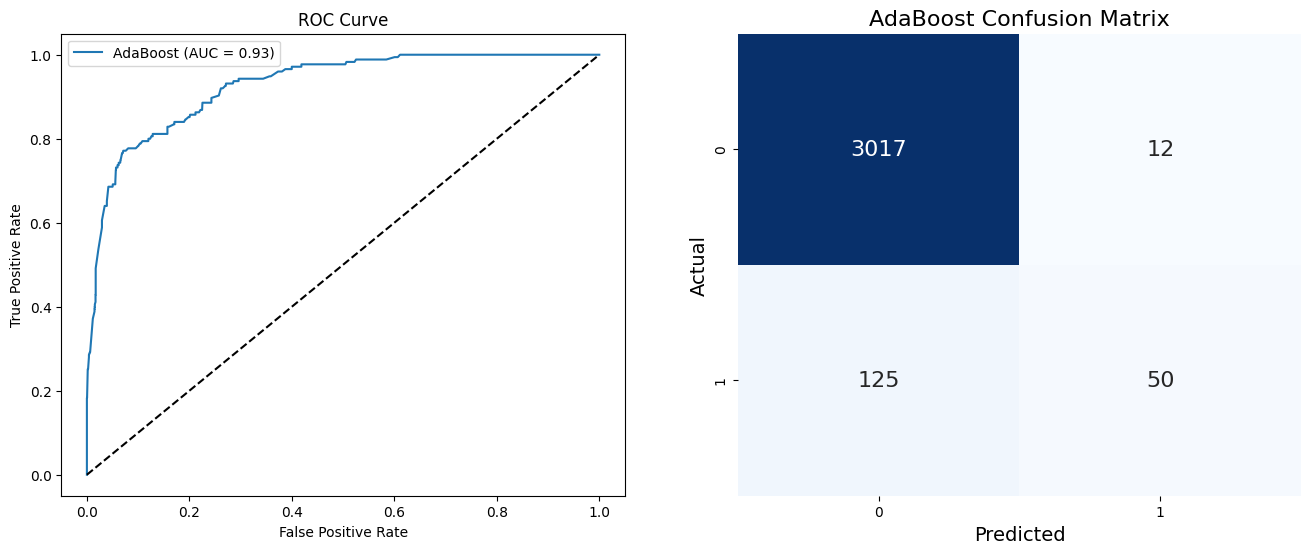

In [28]:
results = {}

# Evaluate each best model
for model_name, best_model in best_models.items():
    print(f"\nEvaluating {model_name}...")

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Sensitivity (Recall)
    sensitivity = recall

    # Specificity
    cm = confusion_matrix(y_test, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])

    # Store results
    results[model_name] = {
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Confusion Matrix:\n{cm}")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, ax=axes[1])
    axes[1].set_xlabel('Predicted', fontsize=14)
    axes[1].set_ylabel('Actual', fontsize=14)
    axes[1].set_title(f'{model_name} Confusion Matrix', fontsize=16)

    plt.show()


In [29]:
metrics_results = {k: {metric: v for metric, v in res.items() if metric != 'best_estimator'} for k, res in results.items()}
metrics_df = pd.DataFrame(metrics_results).T
print("\nEvaluation Metrics Without Sampling:")
metrics_df.head()


Evaluation Metrics Without Sampling:


precision        f1   roc_auc  sensitivity  specificity
RandomForest       0.853333  0.787692  0.948653     0.731429     0.992737
GradientBoosting   0.833333  0.785498  0.952164     0.742857     0.991416
AdaBoost           0.806452  0.421941  0.926829     0.285714     0.996038

#### 4.1.1 Model Performance Without Resampling

I will start by discussing the best evaluation metrics important for selecting the best model, We should also understand the fact that `Accuracy` is not the best evaluation metrics for an imbalance data case.
Each of these metrics provides unique insights into the performance of a classification model:

- Precision focuses on the accuracy of positive predictions.
- F1 Score balances the trade-off between precision and recall.
- ROC AUC evaluates the overall ability of the model to distinguish between classes.
- Sensitivity (Recall) measures the model's ability to identify positive instances.
- Specificity measures the model's ability to identify negative instances.




After getting the best hyperparameter for the model using gridsearch CV, we trained our model with the best hyperparrameter and the table above shows the result without resampling.
It is obvious that `Random Forest` outperform other two models based on having the highest `prescision`, `roc_auc`, `sensitivity` and `specitivity`.

On the other hand, we should take note that models trained on imbalanced datasets without resampling tend to be biased towards the majority class. This can result in high accuracy and precision for the majority class but poor performance on the minority class.

For example, the AdaBoost model without resampling has a high precision but very low sensitivity (0.285714), indicating it fails to identify a significant portion of the minority class instances. In addition the sensitivity of other models is also quite low at a bit over 70%

Futherrmore, high precision but low sencitivity can be problematic in applications where identifying the minority class correctly is critical. And while `ROC AUC` values are high without resampling, they may not fully capture the model’s performance on imbalanced data, as `ROC AUC` considers both false positives and false negatives.

In this case, the goal is to ensure that all potential habitats are identified for conservation, even at the cost of some false positives.

**`Therefore if our model fail to predict Common swift where the Common swift is present (false negative), there can be severe consequences, such as failing to protect a critical habitat or missing an important conservation opportunity, Therefore, high sensitivity is crucial.`**


 This leads us to applying resampling method in other to be able to identify a significant and predict a significant portion of the minorrity class

### 4.5 Train with Resampling

In [30]:
# Resampling methods
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'SVMSMOTE': SVMSMOTE(random_state=42)
}

In [31]:
# Resample the training data and store in a dictionary
resampled_data = {}
for resampling_name, resampling_method in resampling_methods.items():
    X_resampled, y_resampled = resampling_method.fit_resample(X_train, y_train)
    resampled_data[resampling_name] = {'X_train': X_resampled, 'y_train': y_resampled}


In [32]:
cv_results_2 = []
best_models = {}

# Loop through each resampling method
for resampling_name, data in resampled_data.items():
    print(f"\nUsing Resampling Method: {resampling_name}")

    X_resampled = data['X_train']
    y_resampled = data['y_train']

    for model_name, model in tqdm(models.items()):
        print(f"\nPerforming Grid Search for {model_name} with {resampling_name}...")

        pipeline = Pipeline([
            ('classifier', model)
        ])

        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1', n_jobs=-1, verbose=1)
        grid_search.fit(X_resampled, y_resampled)

        mean_cv_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        print(f"{model_name} Best CV F1 Score: {mean_cv_score:.4f}")
        print(f"{model_name} Best Hyperparameters: {best_params}")

        # Store the best model based on resampling method and model name
        if resampling_name not in best_models:
            best_models[resampling_name] = {}
        best_models[resampling_name][model_name] = best_model

        cv_results_2.append({
            'Resampling': resampling_name,
            'Model': model_name,
            'Best CV F1 Score': mean_cv_score,
            'Best Hyperparameters': best_params
        })


Using Resampling Method: SMOTE


  0%|          | 0/3 [00:00<?, ?it/s]


Performing Grid Search for RandomForest with SMOTE...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [04:55<09:50, 295.50s/it]

RandomForest Best CV F1 Score: 0.9619
RandomForest Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Performing Grid Search for GradientBoosting with SMOTE...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 67%|██████▋   | 2/3 [09:57<04:59, 299.51s/it]

GradientBoosting Best CV F1 Score: 0.9669
GradientBoosting Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Performing Grid Search for AdaBoost with SMOTE...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 3/3 [10:24<00:00, 208.21s/it]


AdaBoost Best CV F1 Score: 0.8525
AdaBoost Best Hyperparameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}

Using Resampling Method: ADASYN


  0%|          | 0/3 [00:00<?, ?it/s]


Performing Grid Search for RandomForest with ADASYN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [05:49<11:39, 349.62s/it]

RandomForest Best CV F1 Score: 0.8982
RandomForest Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Performing Grid Search for GradientBoosting with ADASYN...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 67%|██████▋   | 2/3 [11:52<05:57, 357.40s/it]

GradientBoosting Best CV F1 Score: 0.9199
GradientBoosting Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Performing Grid Search for AdaBoost with ADASYN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 3/3 [12:21<00:00, 247.31s/it]


AdaBoost Best CV F1 Score: 0.7640
AdaBoost Best Hyperparameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}

Using Resampling Method: BorderlineSMOTE


  0%|          | 0/3 [00:00<?, ?it/s]


Performing Grid Search for RandomForest with BorderlineSMOTE...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [05:30<11:01, 330.83s/it]

RandomForest Best CV F1 Score: 0.9628
RandomForest Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Performing Grid Search for GradientBoosting with BorderlineSMOTE...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 67%|██████▋   | 2/3 [11:19<05:41, 341.53s/it]

GradientBoosting Best CV F1 Score: 0.9659
GradientBoosting Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Performing Grid Search for AdaBoost with BorderlineSMOTE...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 3/3 [11:48<00:00, 236.13s/it]


AdaBoost Best CV F1 Score: 0.8566
AdaBoost Best Hyperparameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}

Using Resampling Method: SVMSMOTE


  0%|          | 0/3 [00:00<?, ?it/s]


Performing Grid Search for RandomForest with SVMSMOTE...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [04:45<09:31, 285.72s/it]

RandomForest Best CV F1 Score: 0.9746
RandomForest Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Performing Grid Search for GradientBoosting with SVMSMOTE...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


 67%|██████▋   | 2/3 [09:27<04:43, 283.45s/it]

GradientBoosting Best CV F1 Score: 0.9762
GradientBoosting Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Performing Grid Search for AdaBoost with SVMSMOTE...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


100%|██████████| 3/3 [09:55<00:00, 198.34s/it]

AdaBoost Best CV F1 Score: 0.8577
AdaBoost Best Hyperparameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}


In [33]:
# Create a summary table for best CV score and best hyperparameters for each model
summary_table = pd.DataFrame(cv_results_2)
print("\nSummary Table:")
summary_table.head(20)


Summary Table:


Resampling             Model  Best CV F1 Score  \
0             SMOTE      RandomForest          0.961910   
1             SMOTE  GradientBoosting          0.966921   
2             SMOTE          AdaBoost          0.852547   
3            ADASYN      RandomForest          0.898158   
4            ADASYN  GradientBoosting          0.919897   
5            ADASYN          AdaBoost          0.763991   
6   BorderlineSMOTE      RandomForest          0.962801   
7   BorderlineSMOTE  GradientBoosting          0.965855   
8   BorderlineSMOTE          AdaBoost          0.856561   
9          SVMSMOTE      RandomForest          0.974600   
10         SVMSMOTE  GradientBoosting          0.976208   
11         SVMSMOTE          AdaBoost          0.857668   

                                 Best Hyperparameters  
0   {'classifier__max_depth': 20, 'classifier__min...  
1   {'classifier__learning_rate': 0.2, 'classifier...  
2   {'classifier__learning_rate': 1, 'classifier__...  
3   {'classifier__max_depth': 20, 'classifier__min...  
4   {'classifier__learning_rate': 0.2, 'classifier...  
5   {'classifier__learning_rate': 1, 'classifier__...  
6   {'classifier__max_depth': None, 'classifier__m...  
7   {'classifier__learning_rate': 0.2, 'classifier...  
8   {'classifier__learning_rate': 1, 'classifier__...  
9   {'classifier__max_depth': 20, 'classifier__min...  
10  {'classifier__learning_rate': 0.2, 'classifier...  
11  {'classifier__learning_rate': 1, 'classifier__...


Evaluating RandomForest with SMOTE...

RandomForest with SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3029
           1       0.59      0.82      0.69       175

    accuracy                           0.96      3204
   macro avg       0.79      0.90      0.83      3204
weighted avg       0.97      0.96      0.96      3204

ROC AUC: 0.96
Confusion Matrix:
[[2930   99]
 [  31  144]]


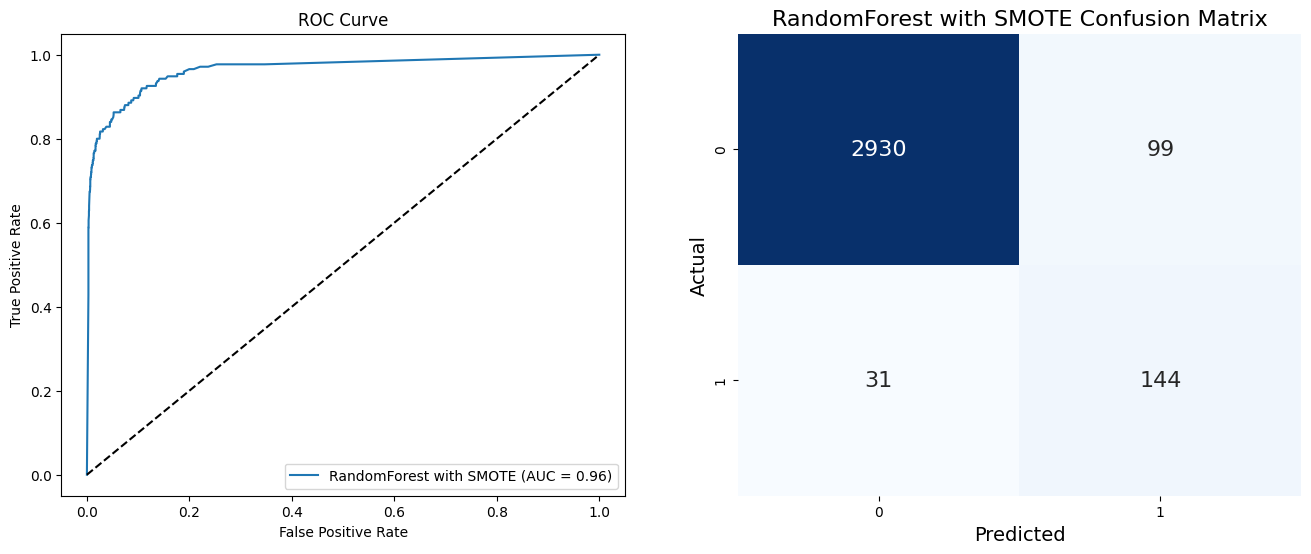


Evaluating GradientBoosting with SMOTE...

GradientBoosting with SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3029
           1       0.63      0.81      0.71       175

    accuracy                           0.96      3204
   macro avg       0.81      0.89      0.84      3204
weighted avg       0.97      0.96      0.97      3204

ROC AUC: 0.96
Confusion Matrix:
[[2947   82]
 [  34  141]]


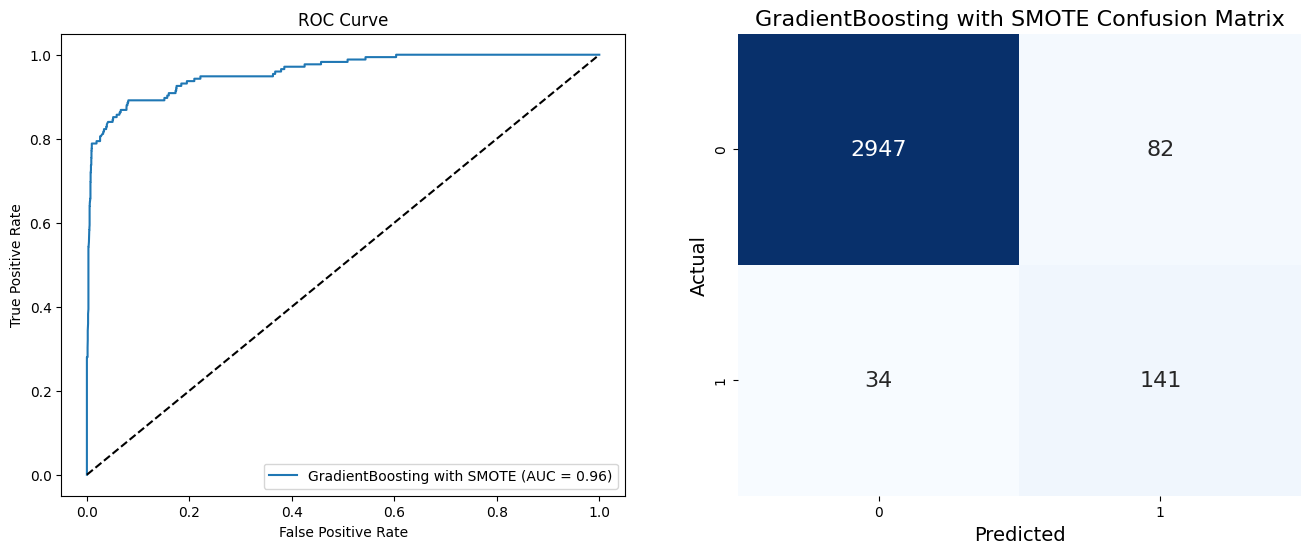


Evaluating AdaBoost with SMOTE...

AdaBoost with SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3029
           1       0.31      0.80      0.45       175

    accuracy                           0.89      3204
   macro avg       0.65      0.85      0.69      3204
weighted avg       0.95      0.89      0.91      3204

ROC AUC: 0.93
Confusion Matrix:
[[2717  312]
 [  35  140]]


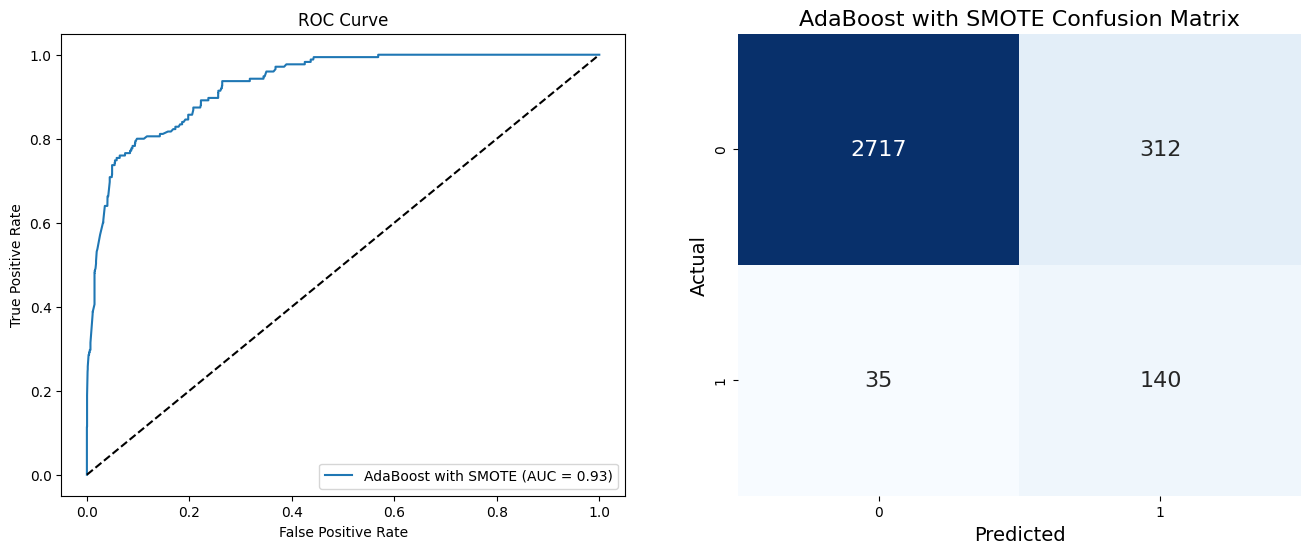


Evaluating RandomForest with ADASYN...

RandomForest with ADASYN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3029
           1       0.50      0.83      0.63       175

    accuracy                           0.95      3204
   macro avg       0.75      0.89      0.80      3204
weighted avg       0.96      0.95      0.95      3204

ROC AUC: 0.97
Confusion Matrix:
[[2884  145]
 [  29  146]]


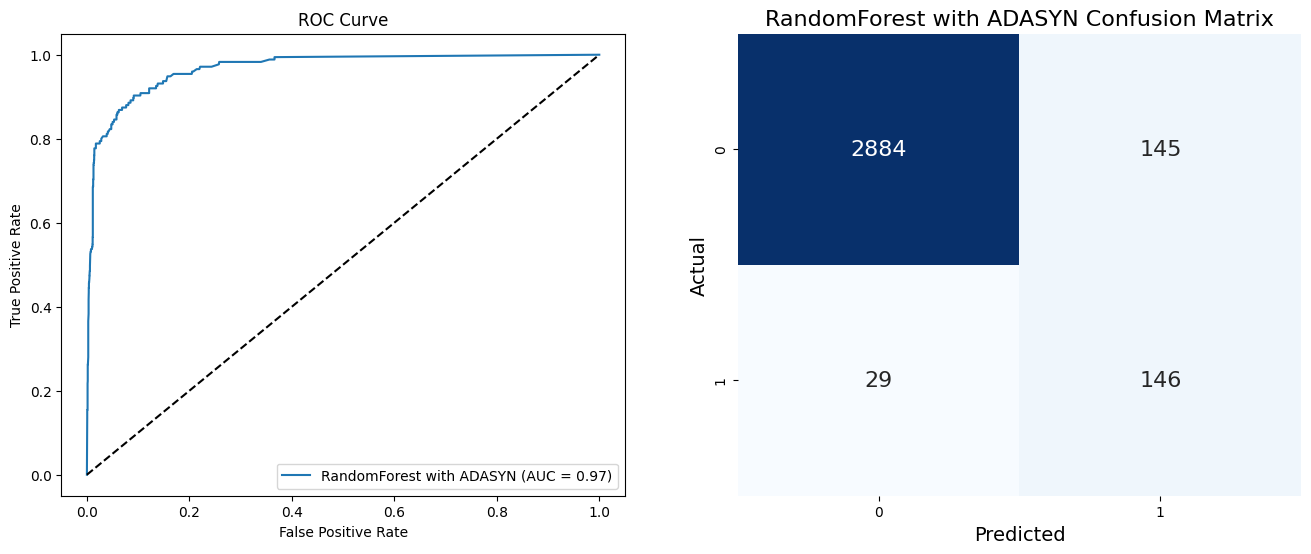


Evaluating GradientBoosting with ADASYN...

GradientBoosting with ADASYN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3029
           1       0.54      0.82      0.65       175

    accuracy                           0.95      3204
   macro avg       0.76      0.89      0.81      3204
weighted avg       0.96      0.95      0.96      3204

ROC AUC: 0.96
Confusion Matrix:
[[2906  123]
 [  31  144]]


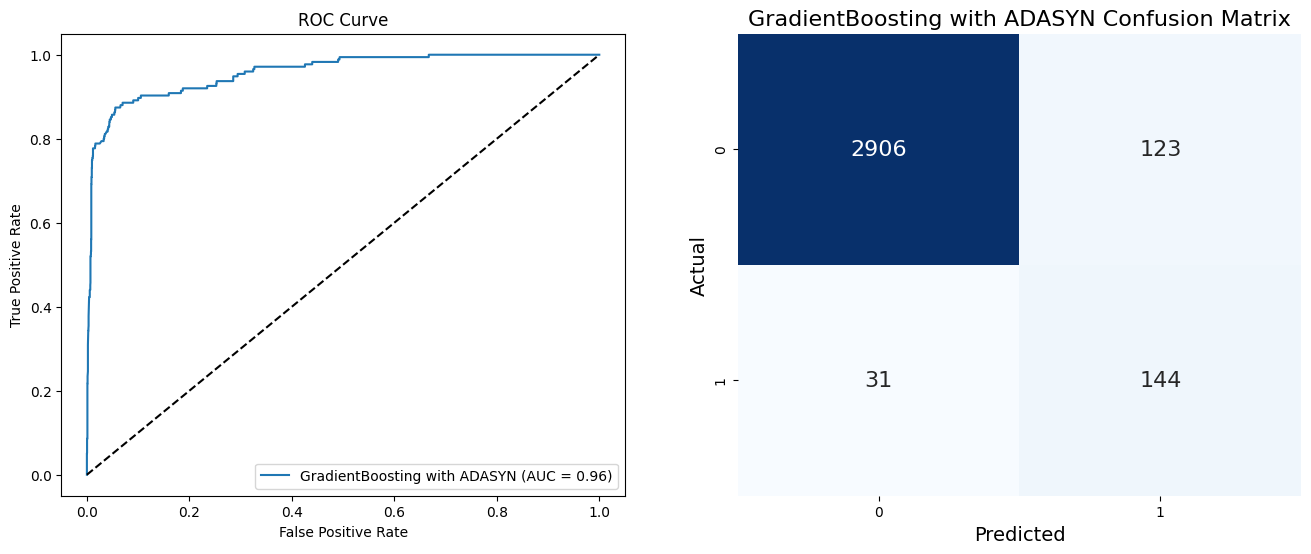


Evaluating AdaBoost with ADASYN...

AdaBoost with ADASYN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      3029
           1       0.17      0.81      0.28       175

    accuracy                           0.78      3204
   macro avg       0.58      0.79      0.58      3204
weighted avg       0.94      0.78      0.84      3204

ROC AUC: 0.90
Confusion Matrix:
[[2345  684]
 [  33  142]]


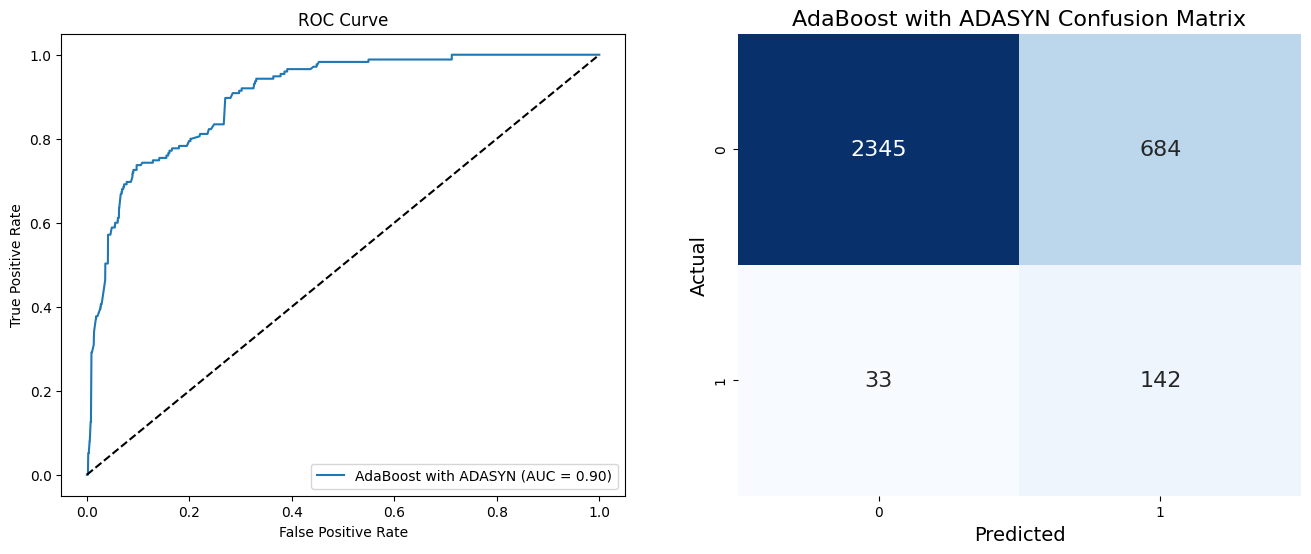


Evaluating RandomForest with BorderlineSMOTE...

RandomForest with BorderlineSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3029
           1       0.67      0.80      0.73       175

    accuracy                           0.97      3204
   macro avg       0.83      0.89      0.86      3204
weighted avg       0.97      0.97      0.97      3204

ROC AUC: 0.97
Confusion Matrix:
[[2961   68]
 [  35  140]]


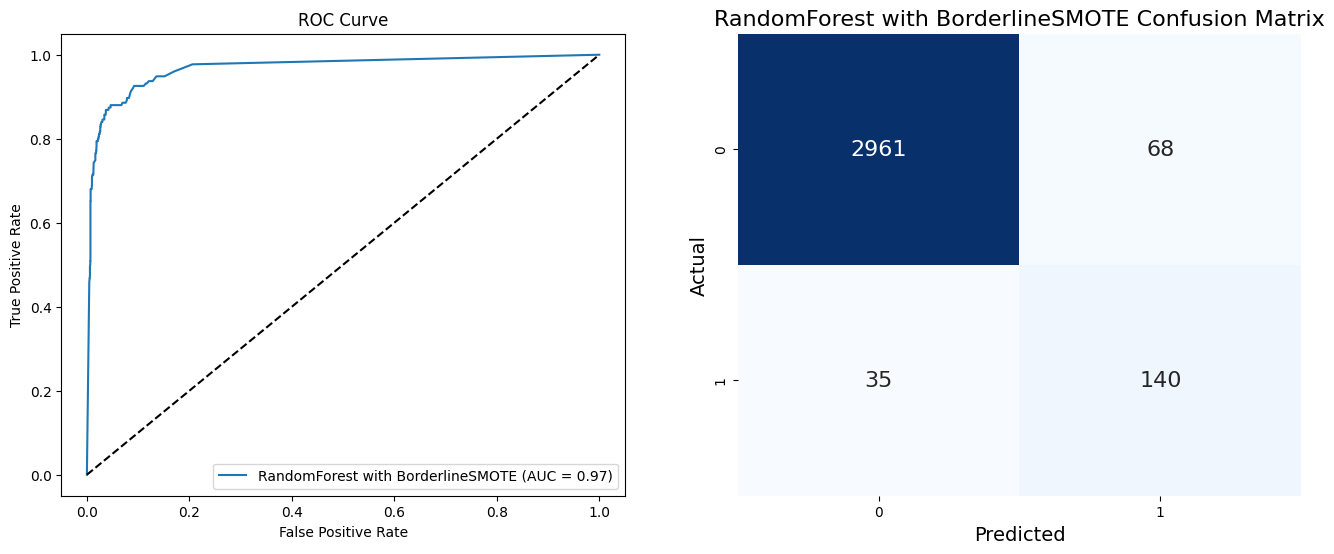


Evaluating GradientBoosting with BorderlineSMOTE...

GradientBoosting with BorderlineSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3029
           1       0.69      0.81      0.74       175

    accuracy                           0.97      3204
   macro avg       0.84      0.89      0.86      3204
weighted avg       0.97      0.97      0.97      3204

ROC AUC: 0.95
Confusion Matrix:
[[2965   64]
 [  34  141]]


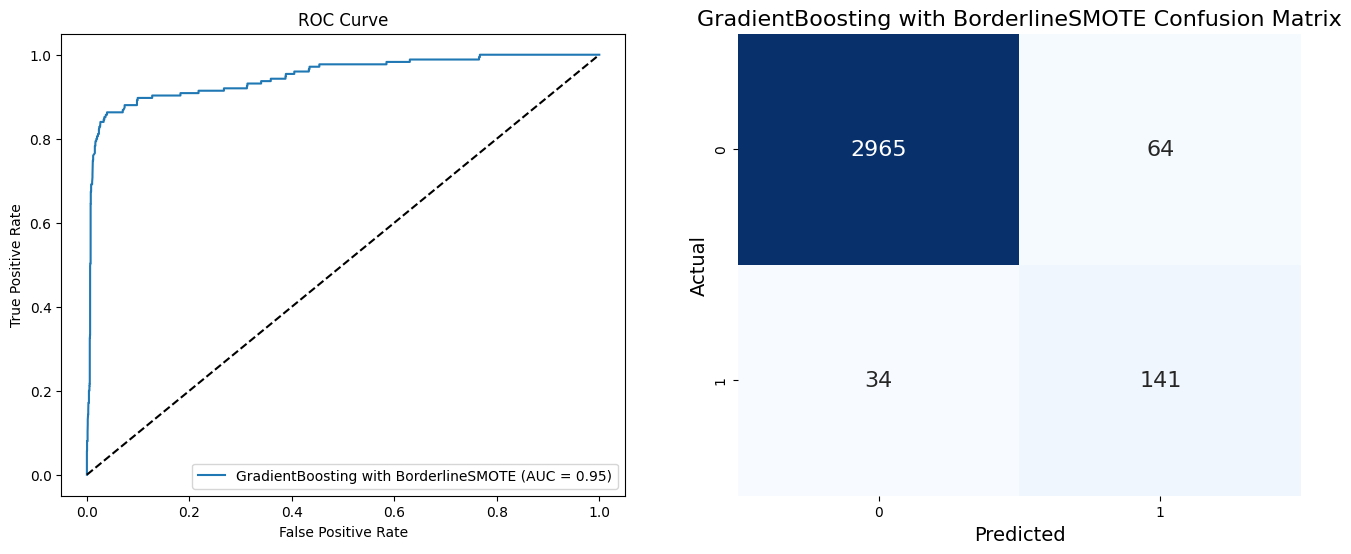


Evaluating AdaBoost with BorderlineSMOTE...

AdaBoost with BorderlineSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3029
           1       0.25      0.86      0.39       175

    accuracy                           0.85      3204
   macro avg       0.62      0.86      0.65      3204
weighted avg       0.95      0.85      0.89      3204

ROC AUC: 0.91
Confusion Matrix:
[[2578  451]
 [  24  151]]


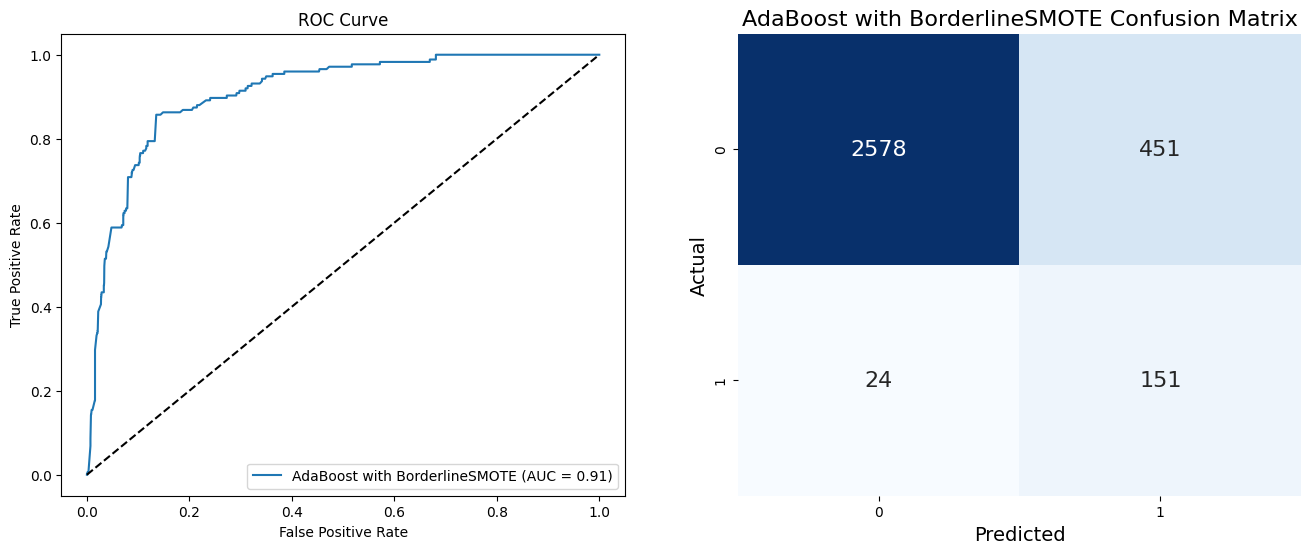


Evaluating RandomForest with SVMSMOTE...

RandomForest with SVMSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3029
           1       0.69      0.81      0.74       175

    accuracy                           0.97      3204
   macro avg       0.84      0.89      0.86      3204
weighted avg       0.97      0.97      0.97      3204

ROC AUC: 0.97
Confusion Matrix:
[[2966   63]
 [  34  141]]


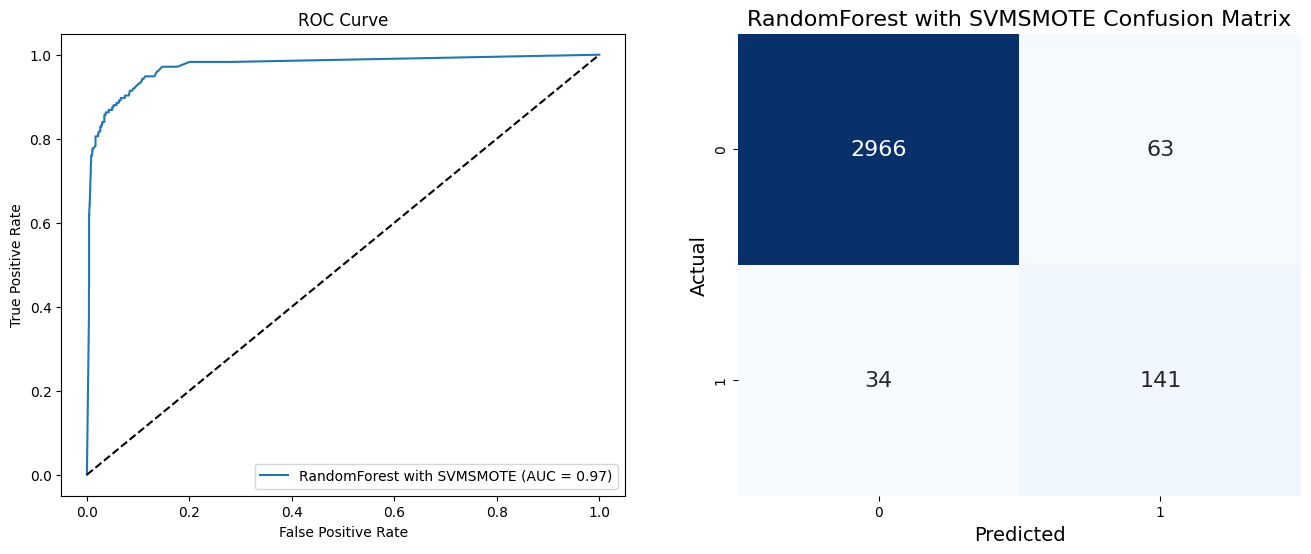


Evaluating GradientBoosting with SVMSMOTE...

GradientBoosting with SVMSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3029
           1       0.71      0.81      0.76       175

    accuracy                           0.97      3204
   macro avg       0.85      0.90      0.87      3204
weighted avg       0.97      0.97      0.97      3204

ROC AUC: 0.96
Confusion Matrix:
[[2970   59]
 [  33  142]]


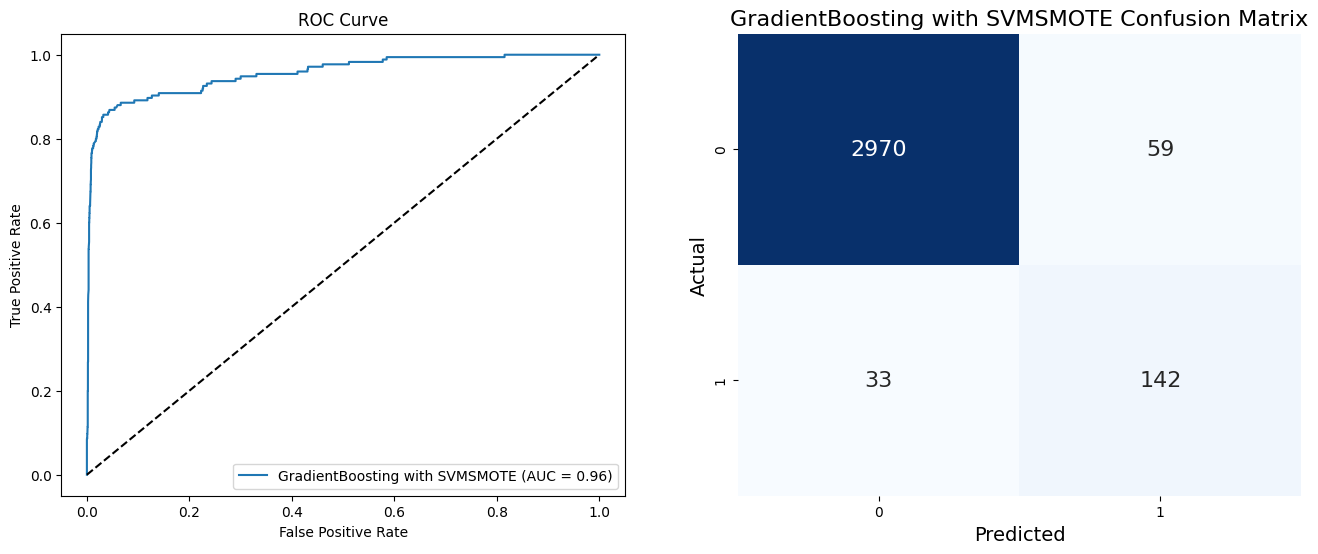


Evaluating AdaBoost with SVMSMOTE...

AdaBoost with SVMSMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3029
           1       0.30      0.79      0.43       175

    accuracy                           0.89      3204
   macro avg       0.64      0.84      0.68      3204
weighted avg       0.95      0.89      0.91      3204

ROC AUC: 0.93
Confusion Matrix:
[[2697  332]
 [  36  139]]


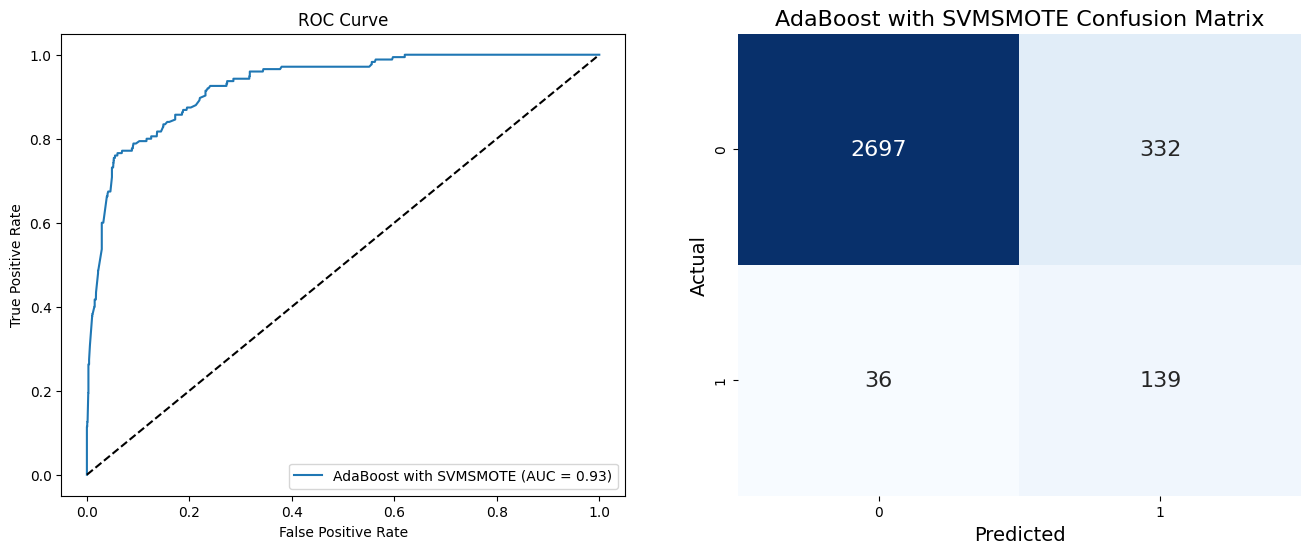

In [34]:
results_2 = {}

# Evaluate each best model
for resampling_name, models_dict in best_models.items():
    for model_name, best_model in models_dict.items():
        print(f"\nEvaluating {model_name} with {resampling_name}...")

        # Make predictions
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        # Sensitivity (Recall)
        sensitivity = recall

        # Specificity
        cm = confusion_matrix(y_test, y_pred)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

        # Store results
        results_2[(resampling_name, model_name)] = {
            'precision': precision,
            'f1': f1,
            'roc_auc': roc_auc,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

        print(f"\n{model_name} with {resampling_name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Confusion Matrix:\n{cm}")

        # Plot ROC curve and confusion matrix side by side
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[0].plot(fpr, tpr, label=f'{model_name} with {resampling_name} (AUC = {roc_auc:.2f})')
        axes[0].plot([0, 1], [0, 1], 'k--')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend()

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, ax=axes[1])
        axes[1].set_xlabel('Predicted', fontsize=14)
        axes[1].set_ylabel('Actual', fontsize=14)
        axes[1].set_title(f'{model_name} with {resampling_name} Confusion Matrix', fontsize=16)

        plt.show()

In [35]:
# Create a summary table for best CV score and best hyperparameters for each model
df = pd.DataFrame.from_dict(results_2, orient='index')
df.reset_index(inplace=True)
df.columns = ['Sampling_Method', 'Model', 'Precision','F1_Score', 'ROC_AUC', 'Sensitivity', 'Specificity']

df.head(20)

Sampling_Method             Model  Precision  F1_Score   ROC_AUC  \
0             SMOTE      RandomForest   0.592593  0.688995  0.964398   
1             SMOTE  GradientBoosting   0.632287  0.708543  0.959355   
2             SMOTE          AdaBoost   0.309735  0.446571  0.930809   
3            ADASYN      RandomForest   0.501718  0.626609  0.967474   
4            ADASYN  GradientBoosting   0.539326  0.651584  0.957991   
5            ADASYN          AdaBoost   0.171913  0.283716  0.901737   
6   BorderlineSMOTE      RandomForest   0.673077  0.731070  0.967770   
7   BorderlineSMOTE  GradientBoosting   0.687805  0.742105  0.948314   
8   BorderlineSMOTE          AdaBoost   0.250831  0.388674  0.909695   
9          SVMSMOTE      RandomForest   0.691176  0.744063  0.971933   
10         SVMSMOTE  GradientBoosting   0.706468  0.755319  0.955494   
11         SVMSMOTE          AdaBoost   0.295117  0.430341  0.929180   

    Sensitivity  Specificity  
0      0.822857     0.967316  
1      0.805714     0.972928  
2      0.800000     0.896996  
3      0.834286     0.952129  
4      0.822857     0.959393  
5      0.811429     0.774183  
6      0.800000     0.977550  
7      0.805714     0.978871  
8      0.862857     0.851106  
9      0.805714     0.979201  
10     0.811429     0.980522  
11     0.794286     0.890393

#### Model Evaluation With Resampling

Since we have justified the fact that our goal is to be able to get an higherr sensitivity, even as we keep some of the other metrics higher to be able to make sure that or model is able to generalize more on the minority class too.

The result above again shows the Resampling methods generally improve sensitivity result of the model. For example, the recall of the Random Forest model increased from 0.731429 (without resampling) to 0.822857 (with SMOTE), indicating better performance in identifying the minority class. This happen to other model and other sampling approch as the sensitivity tends to increase.

Improvement in the `ROC AUC` after resampling also is quite impressive as it indicates that the model has a better balance between sensitivity (recall) and specificity, enhancing overall discriminatory power. For instance, the `ROC AUC` for the Random Forest model increased from 0.948653 (without resampling) to 0.964398 (with SMOTE).

In terms of the best model using the resampling approach, Both models with SVMSMOTE show high sensitivity and good overall performance. Given the slightly higher sensitivity, the Gradient Boosting with SVMSMOTE might be preferred since the sensitivity is the absolute priority.

Finally, we have justified that models without resampling might show high metrics like precision, specitivity and accuracy, they often underperform in recall and sensitivity, which are crucial for identifying minority class.

Therefore, despite potentially lower precision, models with resampling are generally better for deployment where detecting the minority class correctly is imporrtant most especially in our case study.







## 5.0 Optimization and Experimentation:

### 5.1 Model Improvement By Tweaking The Decision Threshold (Bias)

In [36]:
results = []
best_threshold_results = []

# Function to evaluate and store metrics
def evaluate_and_store_results(y_true, y_prob, threshold, resampling_name, model_name):
    y_pred = (y_prob >= threshold).astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    sensitivity = recall

    results.append({
        'Resampling': resampling_name,
        'Model': model_name,
        'Threshold': threshold,
        'Precision': precision,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    })

    return {
        'threshold': threshold,
        'precision': precision,
        'f1': f1,
        'roc_auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

In [37]:
# Functions to identify best thresholds for different strategies
def get_best_f1(metrics_df):
    return metrics_df.loc[metrics_df['f1'].idxmax()]

def get_best_recall(metrics_df):
    return metrics_df.loc[metrics_df['specificity'].idxmax()]

In [38]:
# Function to generate plots
def generate_plots(y_test, y_prob, threshold, strategy, resampling_name, model_name):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # ROC Curve Plot
    axes[0].plot(fpr, tpr, label=f'{model_name} with {resampling_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Precision-Recall Curve Plot
    axes[1].plot(recall, precision, marker='.')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')

    # Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, ax=axes[2])
    axes[2].set_xlabel('Predicted', fontsize=14)
    axes[2].set_ylabel('Actual', fontsize=14)
    axes[2].set_title(f'Confusion Matrix at {threshold}', fontsize=16)

    plt.suptitle(f'{model_name} with {resampling_name} - {strategy}', fontsize=18)
    plt.show()


Evaluating RandomForest with SMOTE...
Best threshold by F1 Score for RandomForest with SMOTE: 0.89


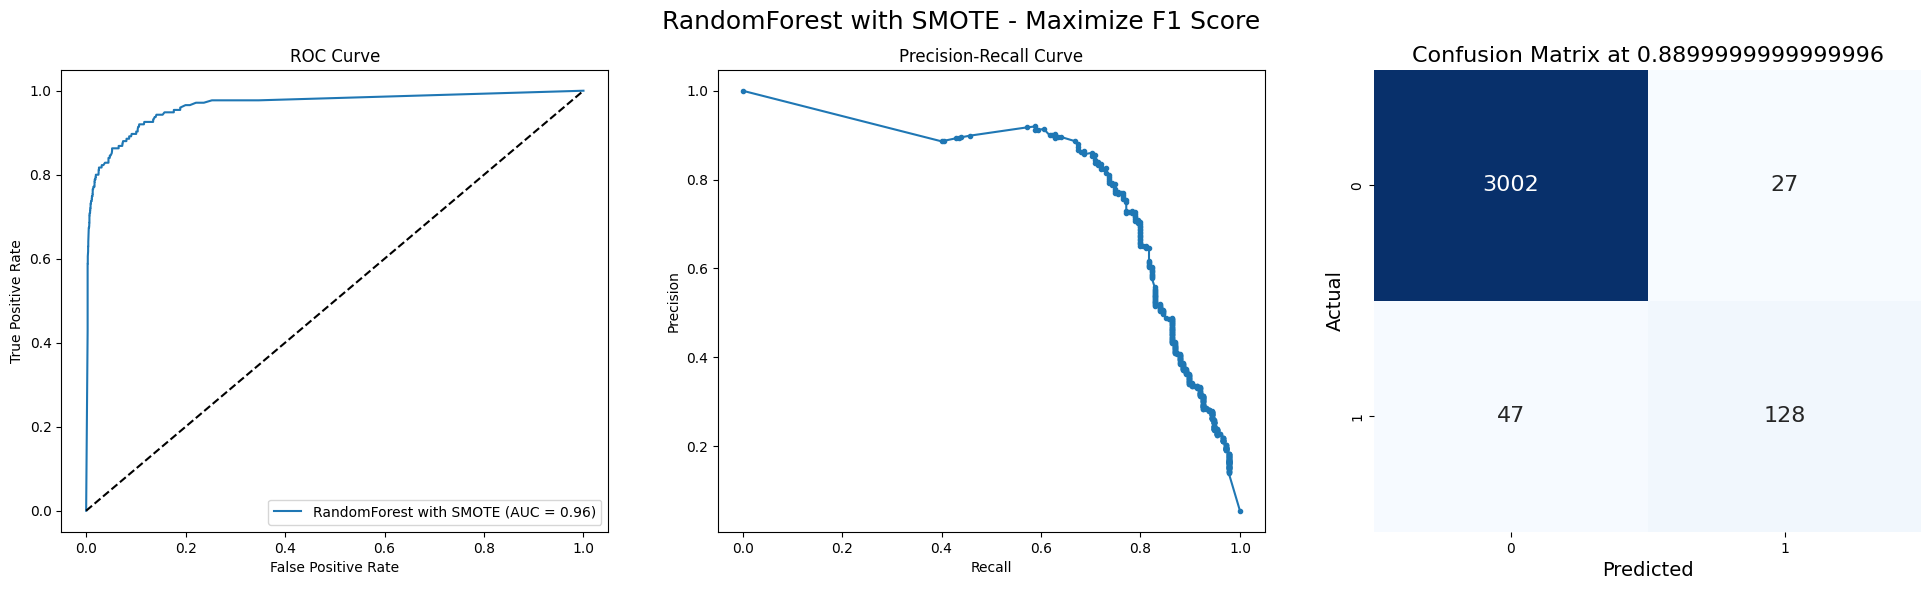

Best threshold by Recall for RandomForest with SMOTE: 0.99


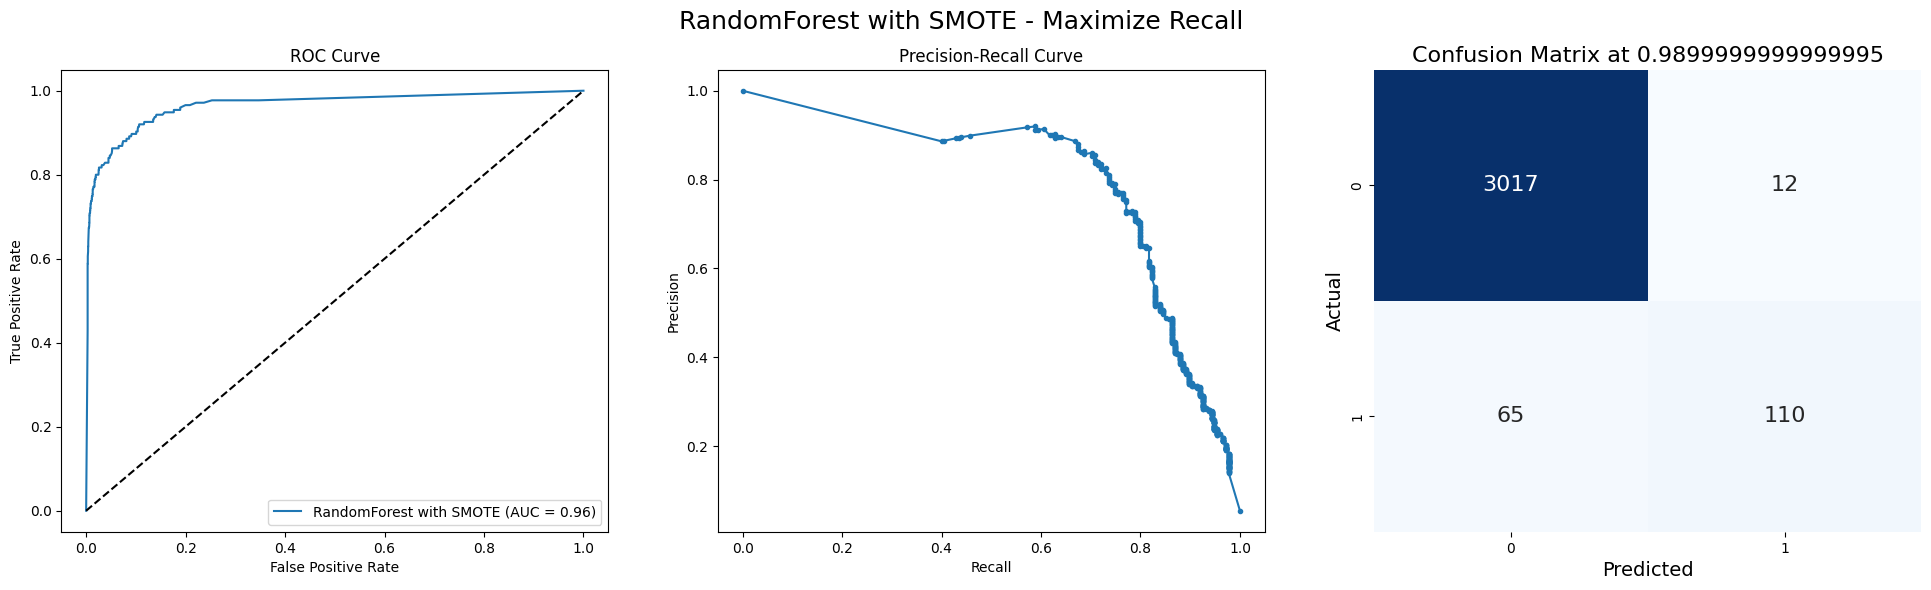


Evaluating GradientBoosting with SMOTE...
Best threshold by F1 Score for GradientBoosting with SMOTE: 0.83


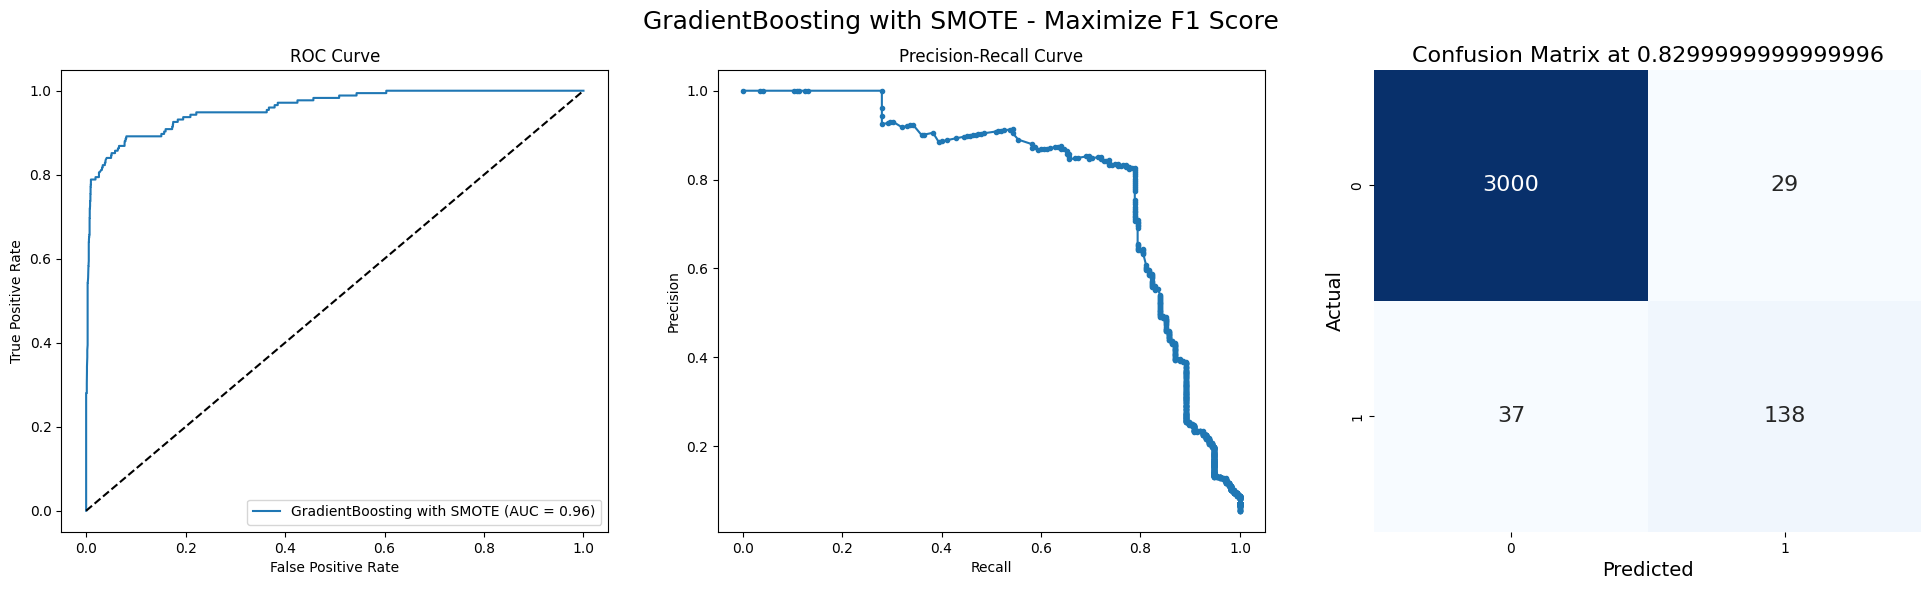

Best threshold by Recall for GradientBoosting with SMOTE: 0.99


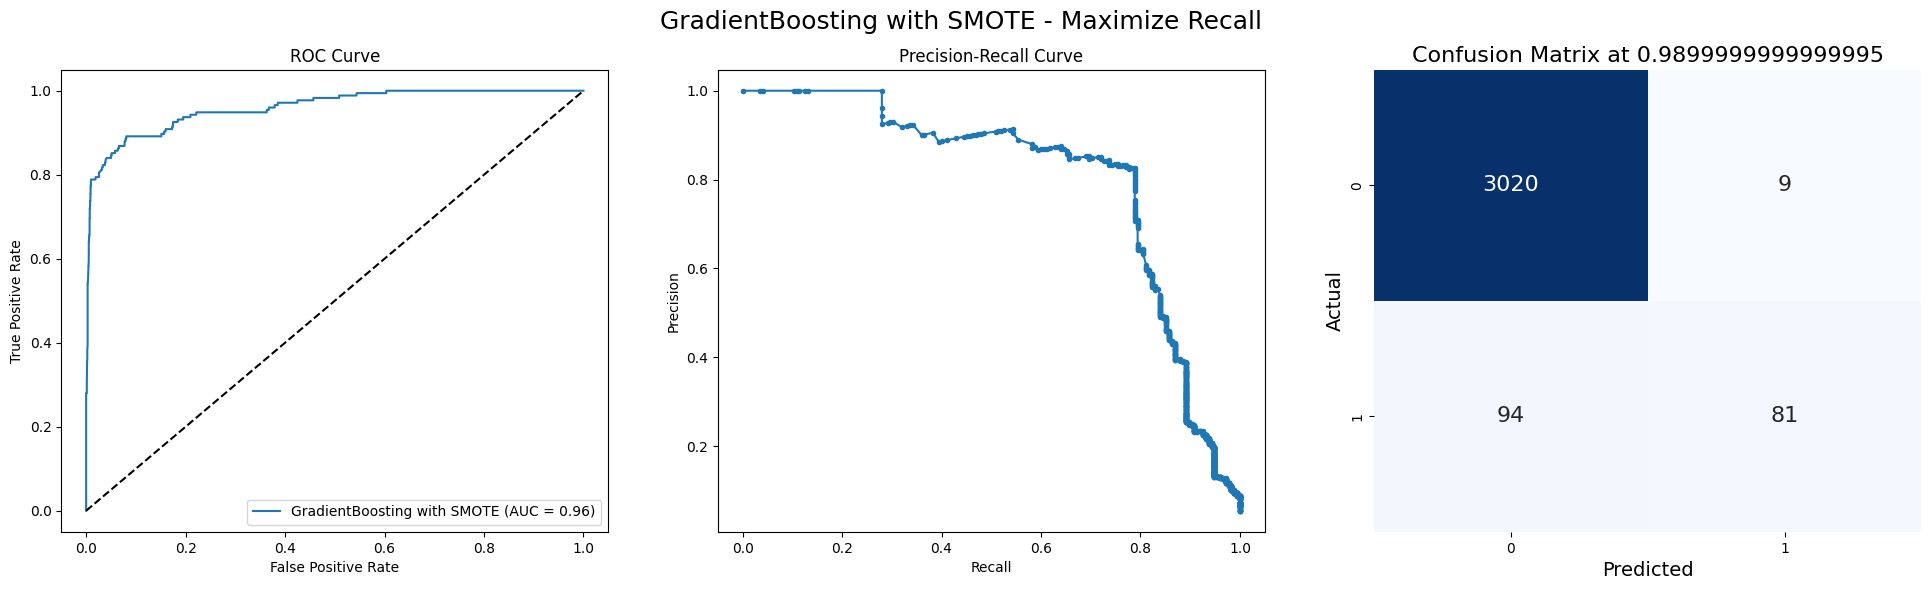


Evaluating AdaBoost with SMOTE...
Best threshold by F1 Score for AdaBoost with SMOTE: 0.50


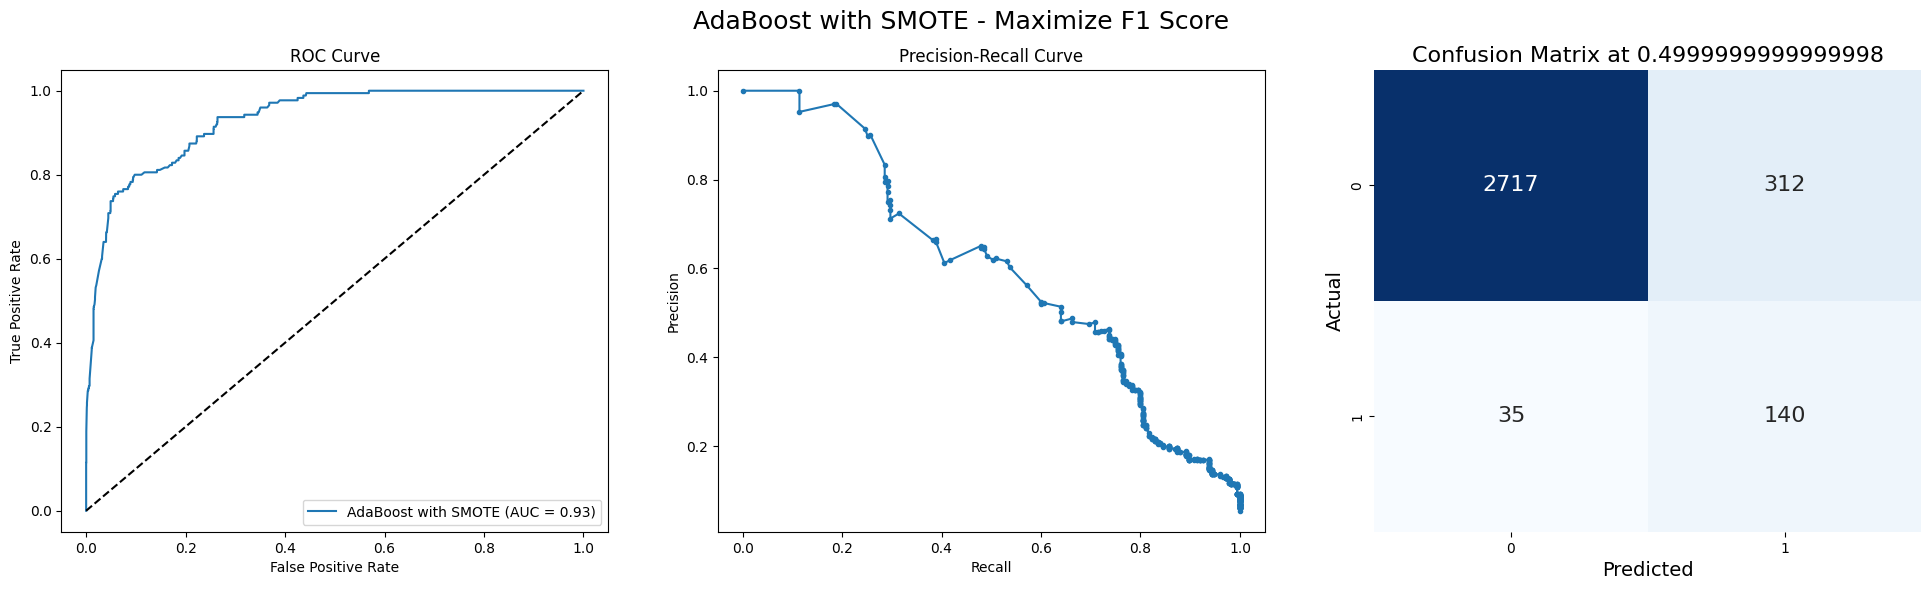

Best threshold by Recall for AdaBoost with SMOTE: 0.52


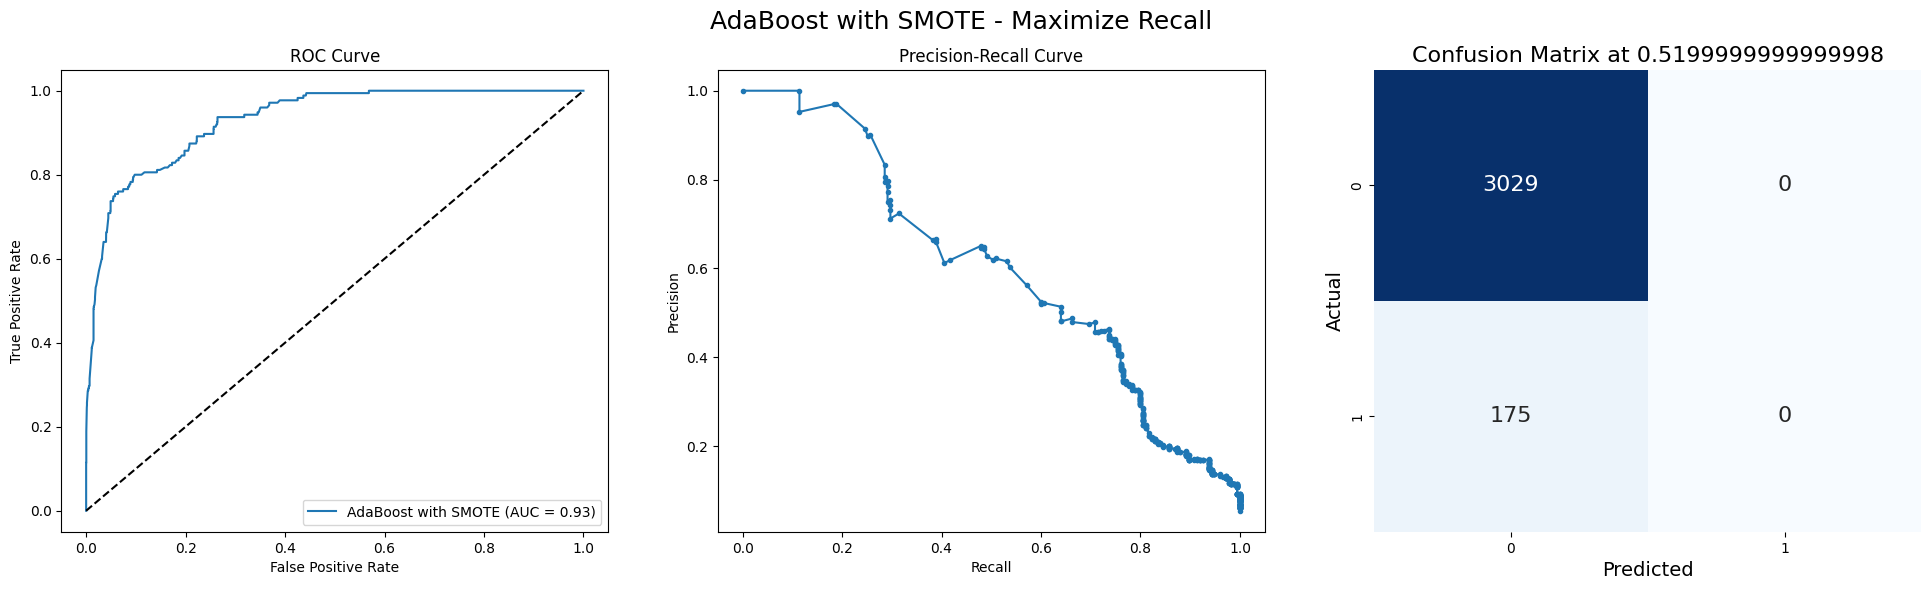


Evaluating RandomForest with ADASYN...
Best threshold by F1 Score for RandomForest with ADASYN: 0.88


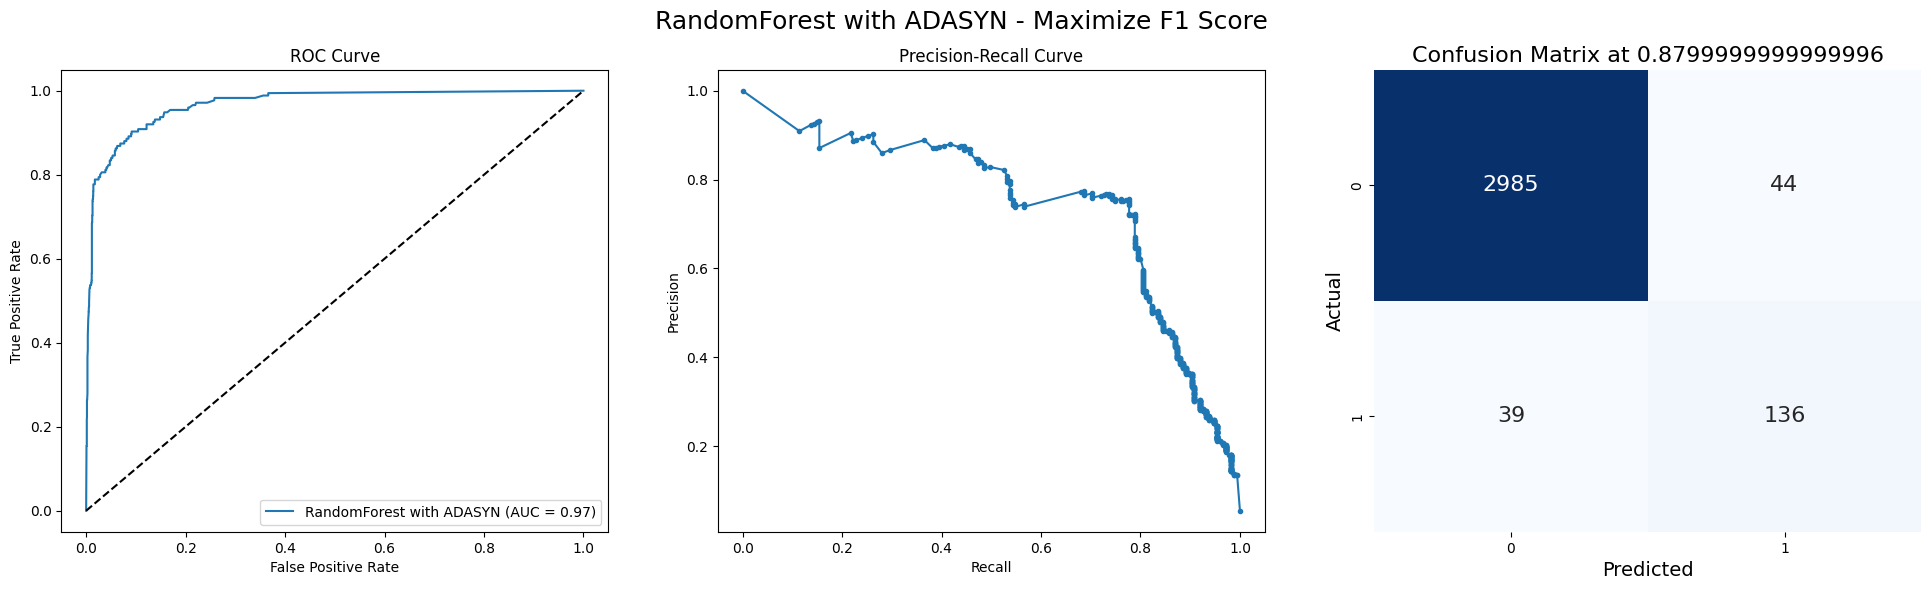

Best threshold by Recall for RandomForest with ADASYN: 0.99


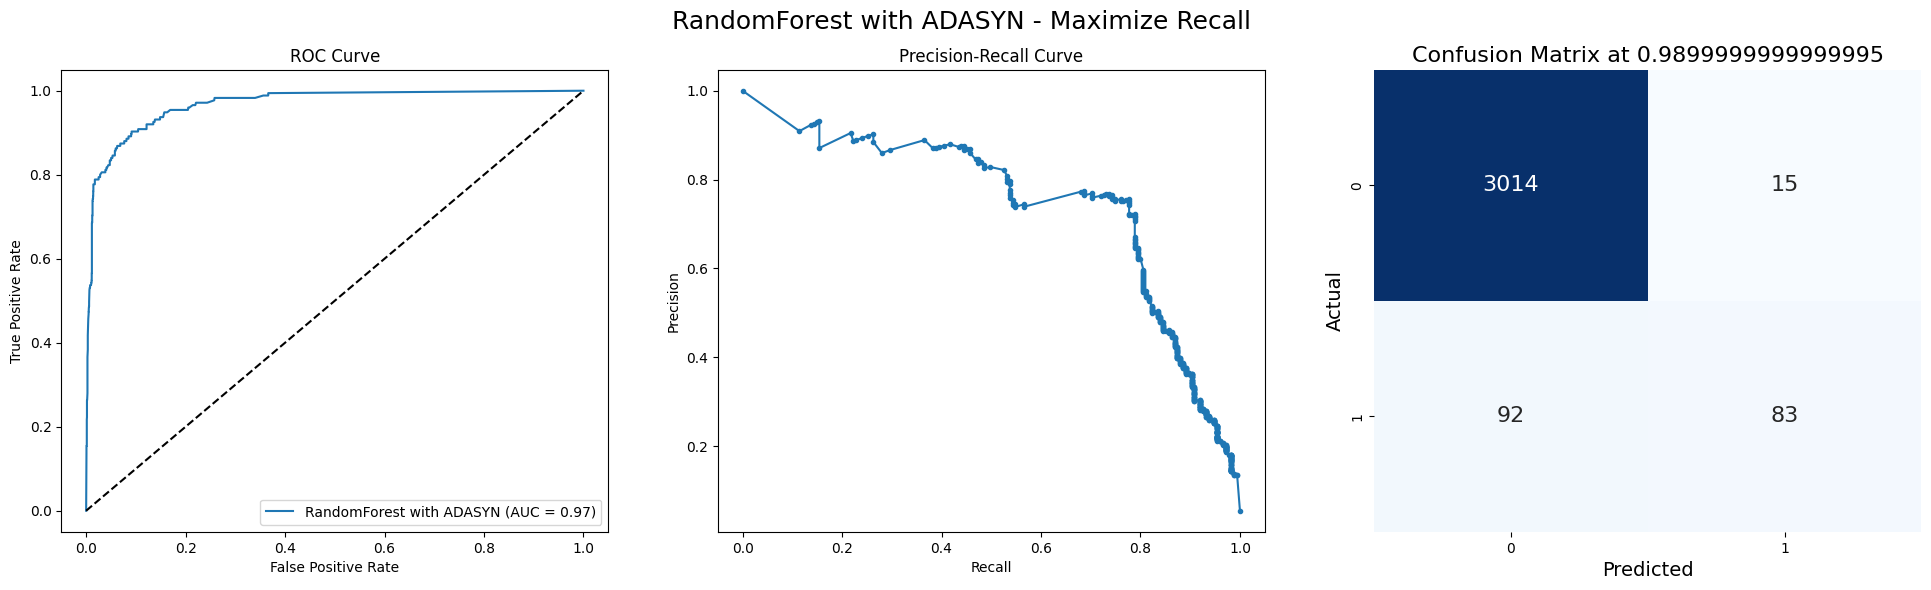


Evaluating GradientBoosting with ADASYN...
Best threshold by F1 Score for GradientBoosting with ADASYN: 0.88


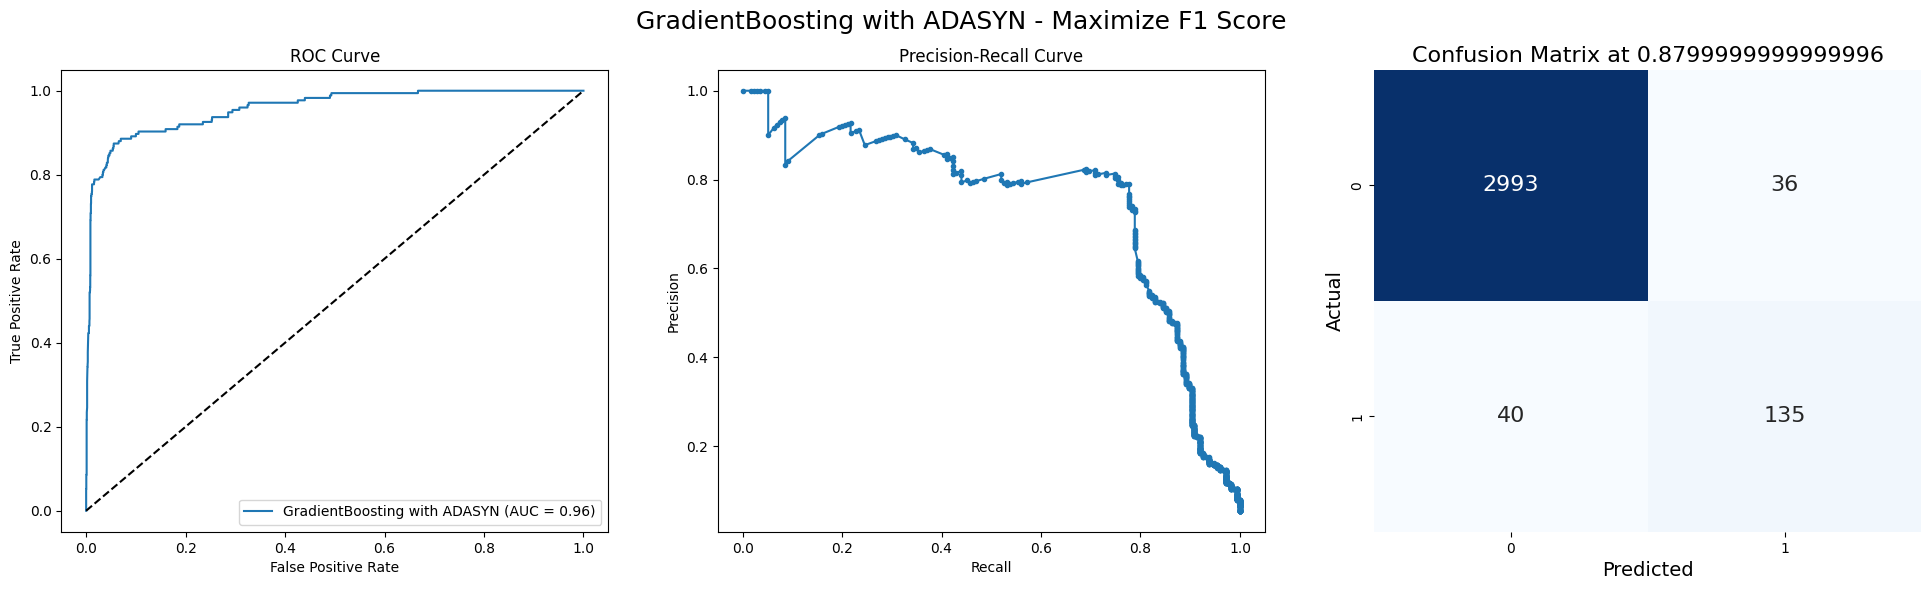

Best threshold by Recall for GradientBoosting with ADASYN: 0.99


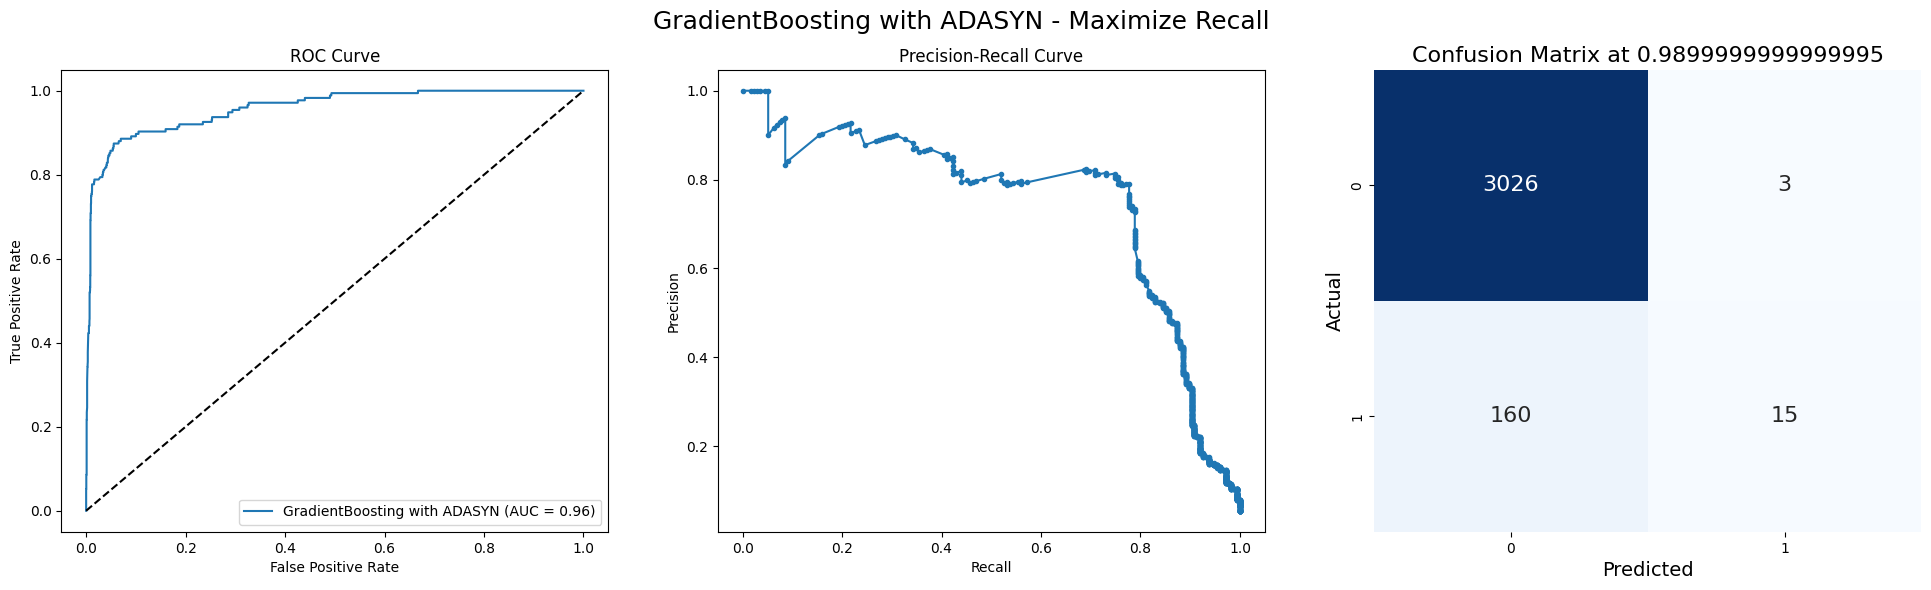


Evaluating AdaBoost with ADASYN...
Best threshold by F1 Score for AdaBoost with ADASYN: 0.50


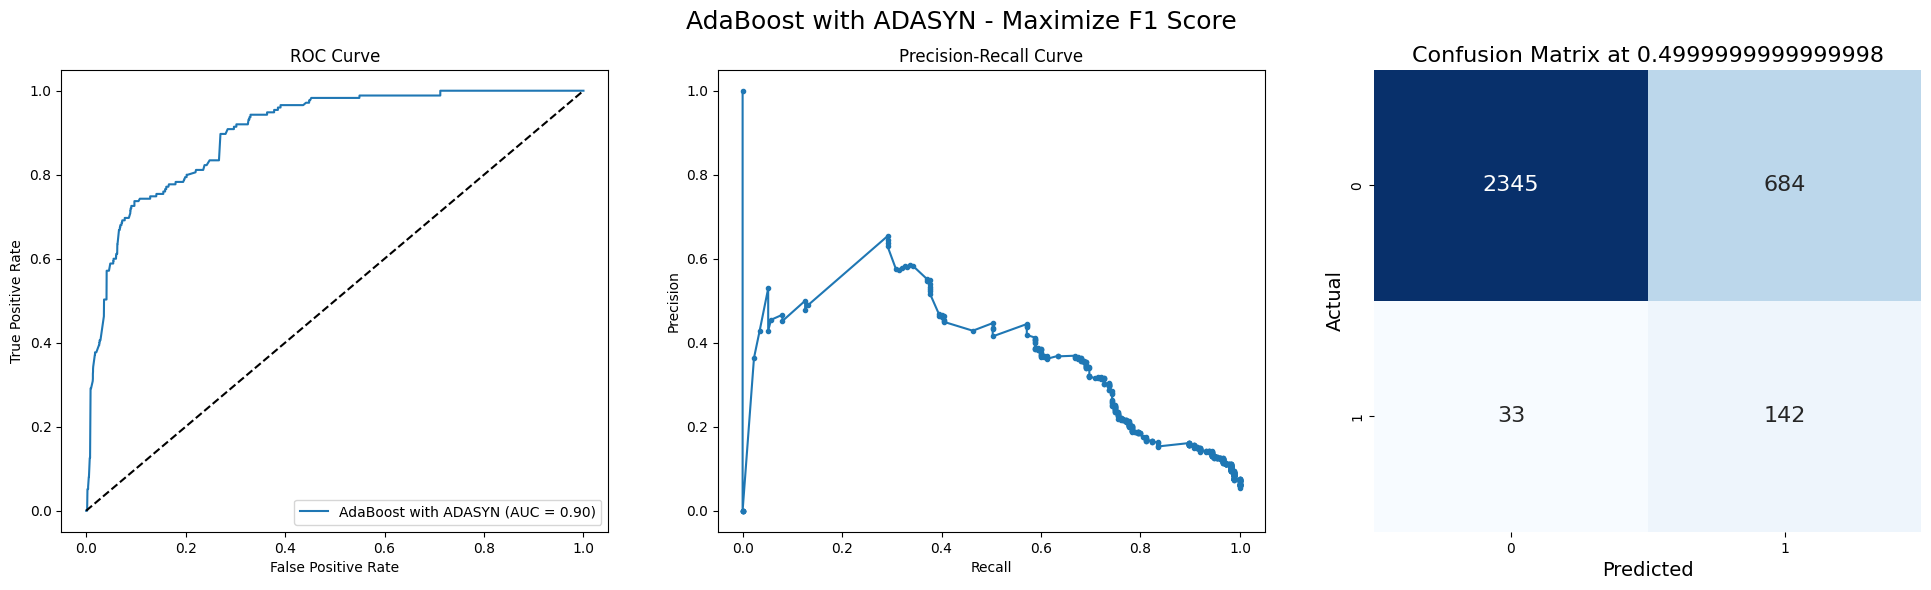

Best threshold by Recall for AdaBoost with ADASYN: 0.51


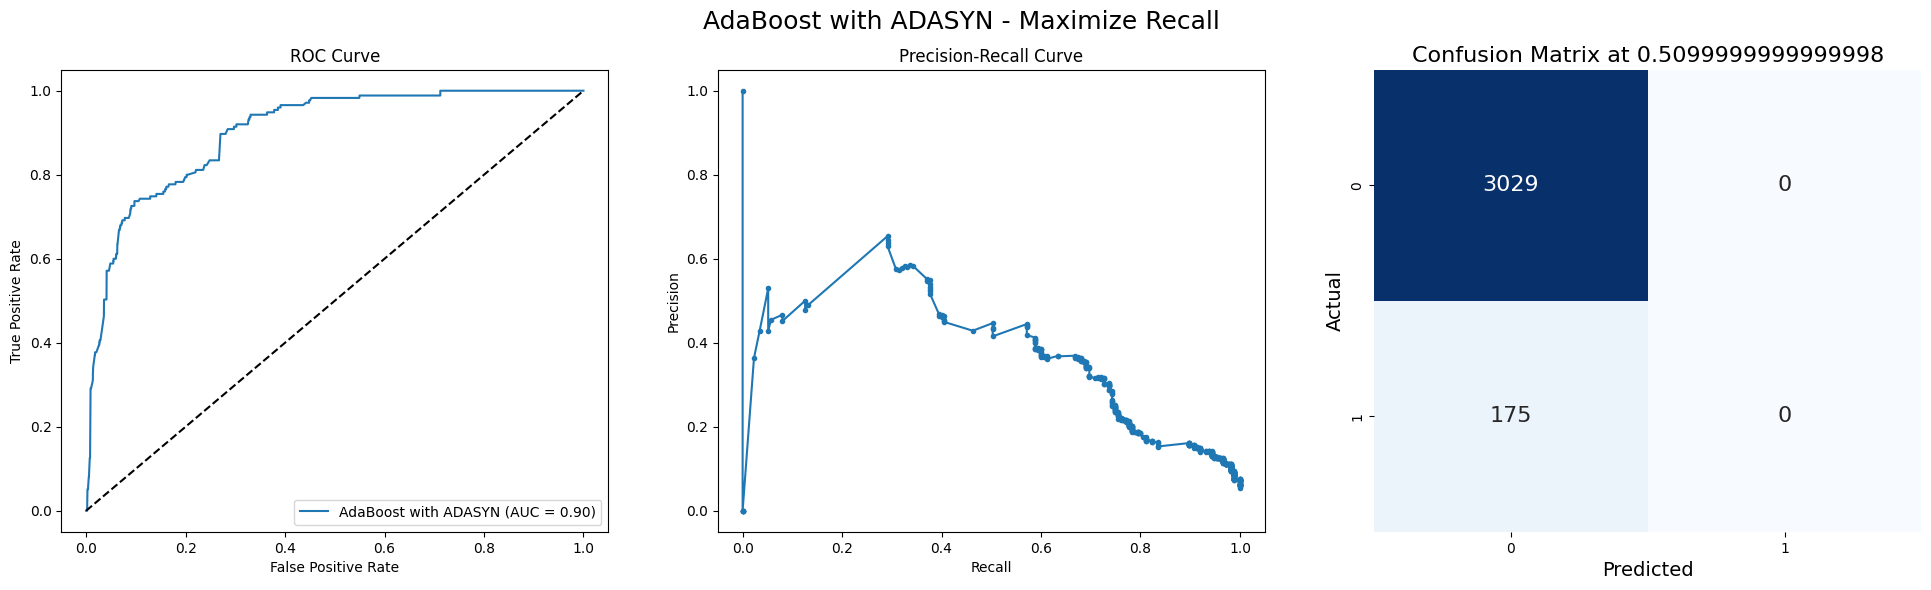


Evaluating RandomForest with BorderlineSMOTE...
Best threshold by F1 Score for RandomForest with BorderlineSMOTE: 0.88


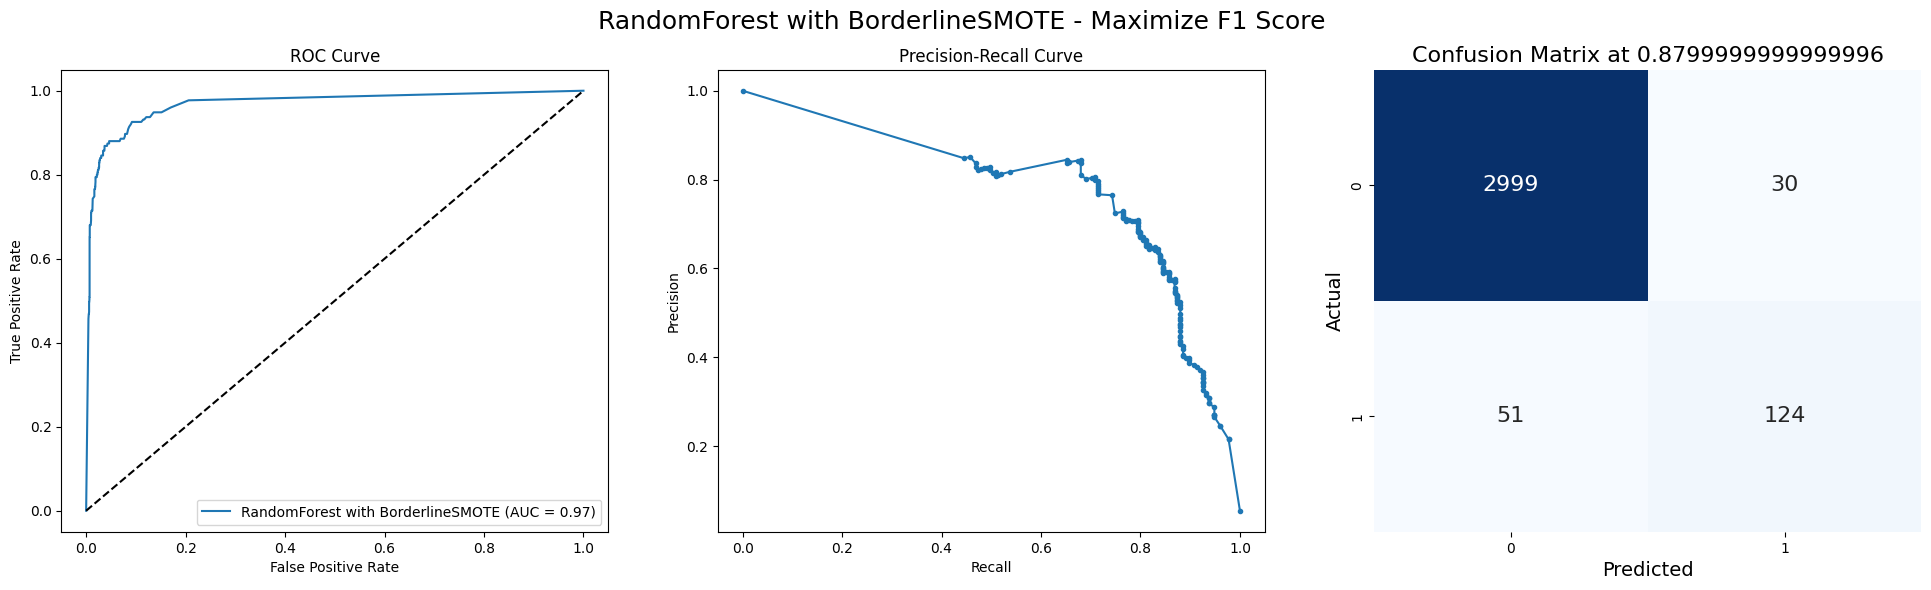

Best threshold by Recall for RandomForest with BorderlineSMOTE: 0.98


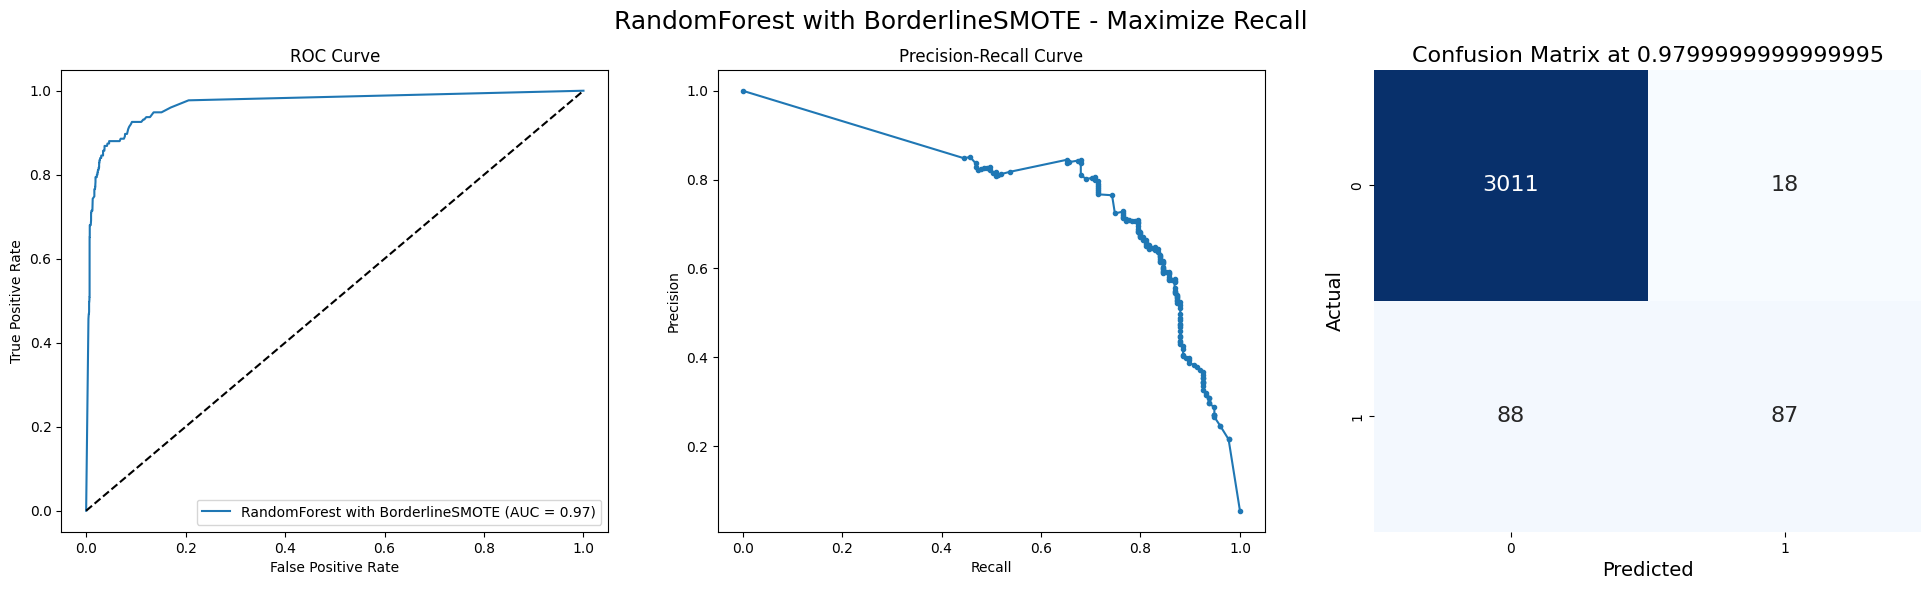


Evaluating GradientBoosting with BorderlineSMOTE...
Best threshold by F1 Score for GradientBoosting with BorderlineSMOTE: 0.80


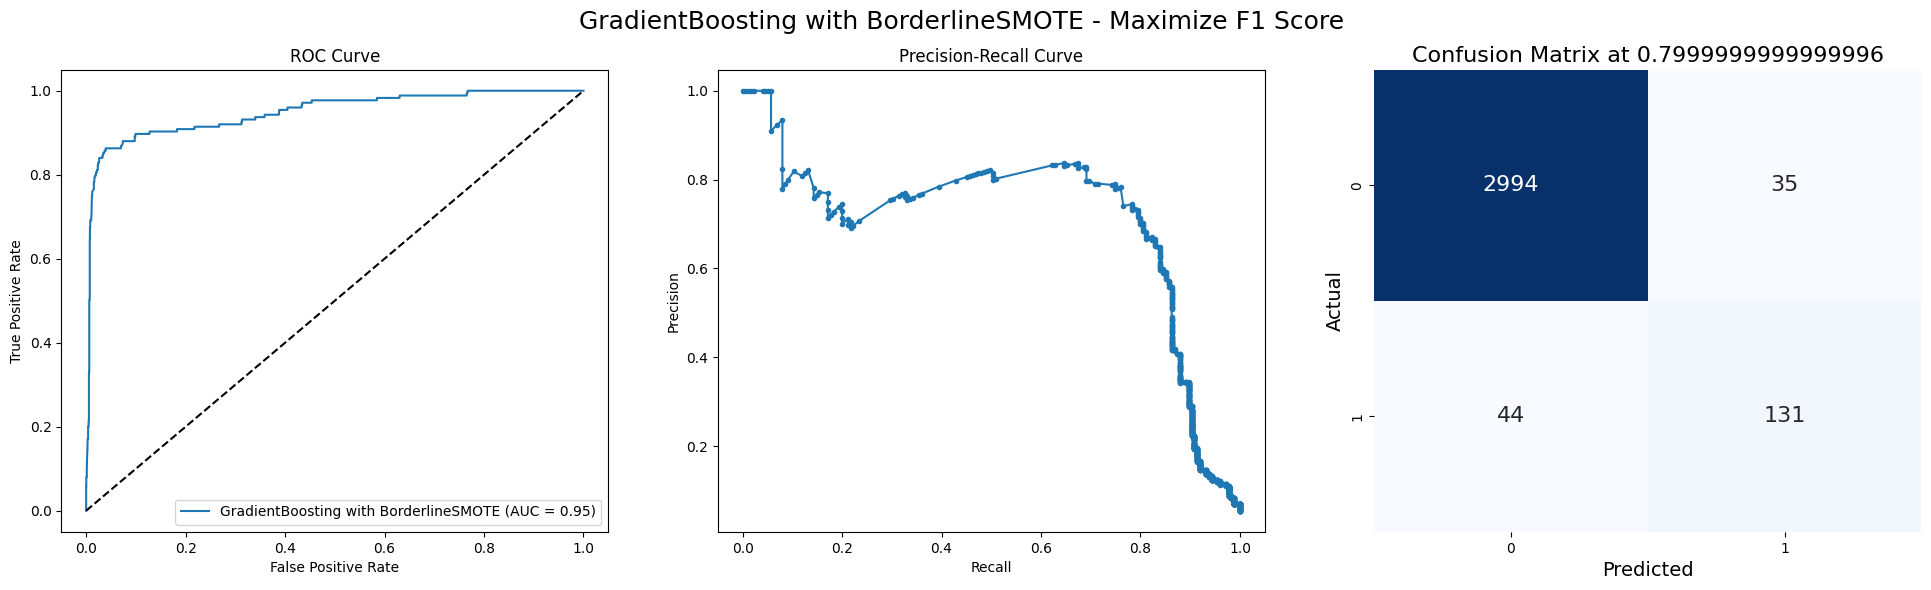

Best threshold by Recall for GradientBoosting with BorderlineSMOTE: 0.99


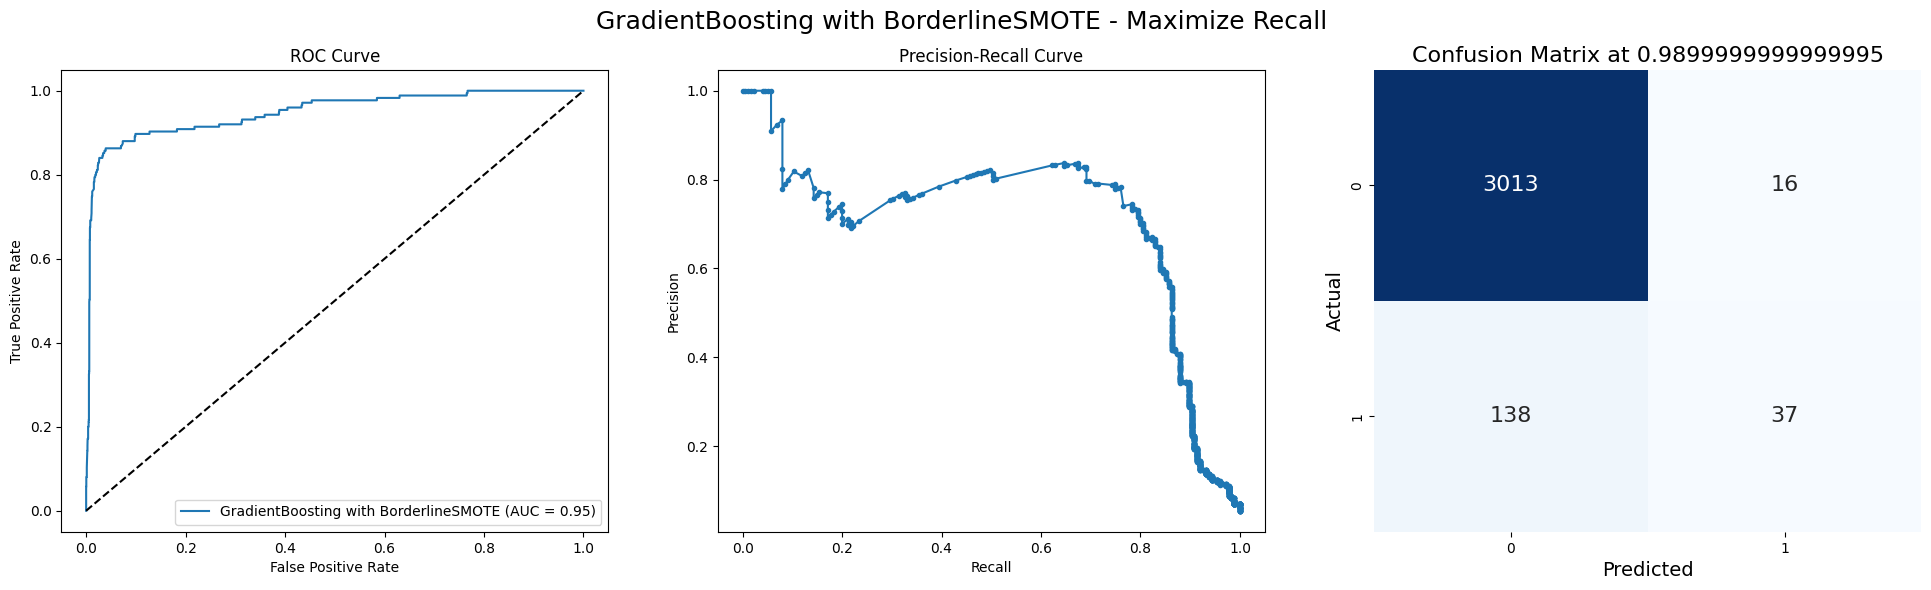


Evaluating AdaBoost with BorderlineSMOTE...
Best threshold by F1 Score for AdaBoost with BorderlineSMOTE: 0.50


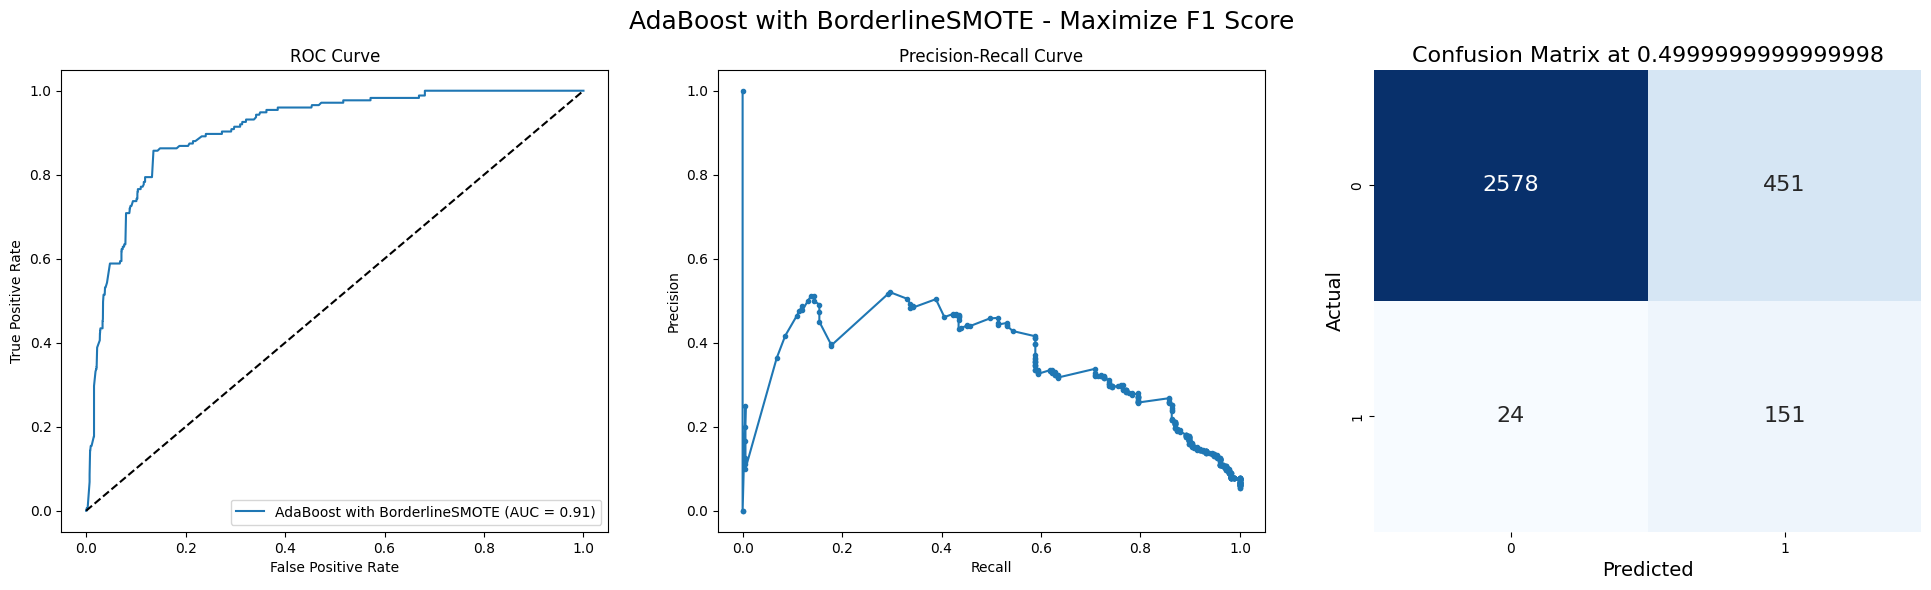

Best threshold by Recall for AdaBoost with BorderlineSMOTE: 0.52


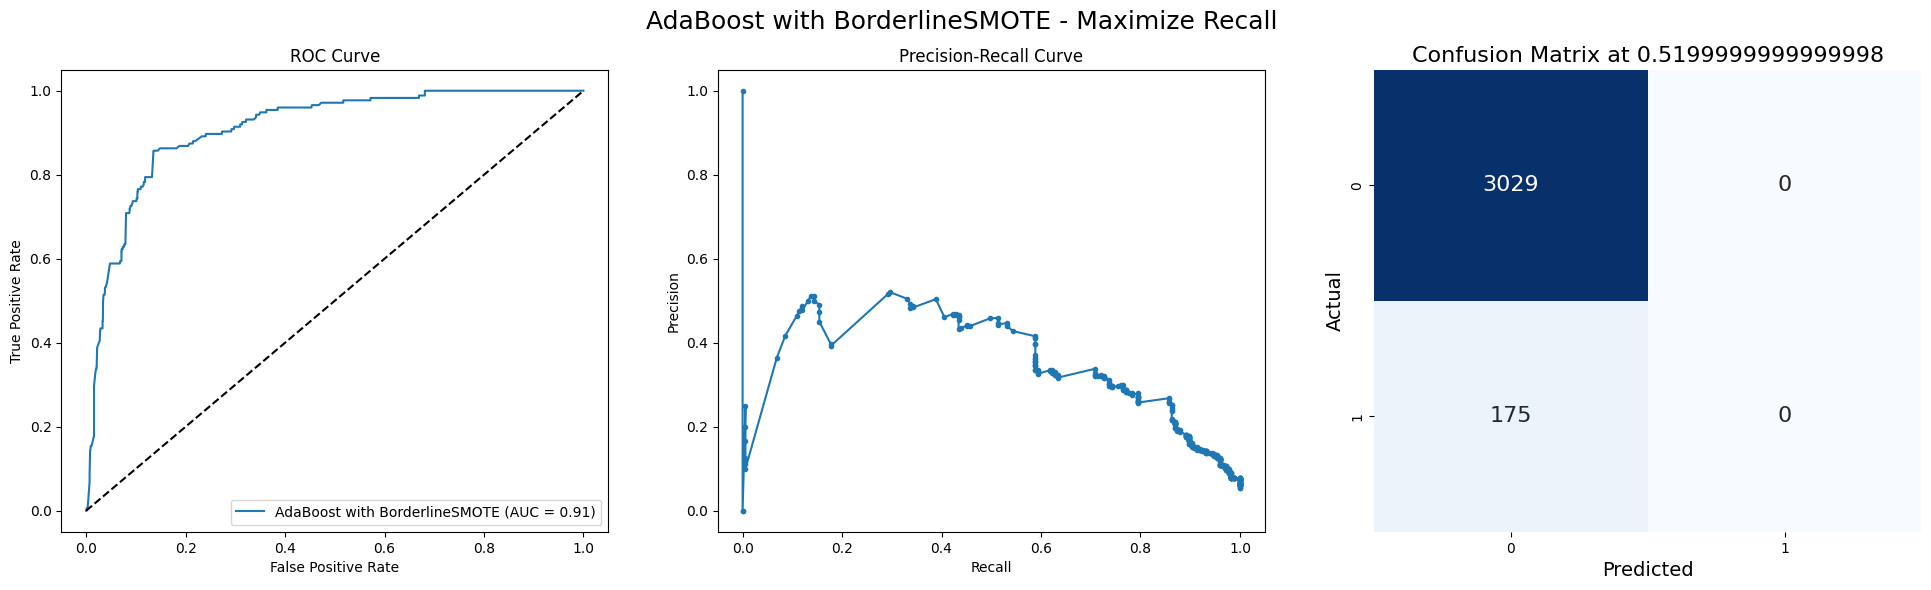


Evaluating RandomForest with SVMSMOTE...
Best threshold by F1 Score for RandomForest with SVMSMOTE: 0.84


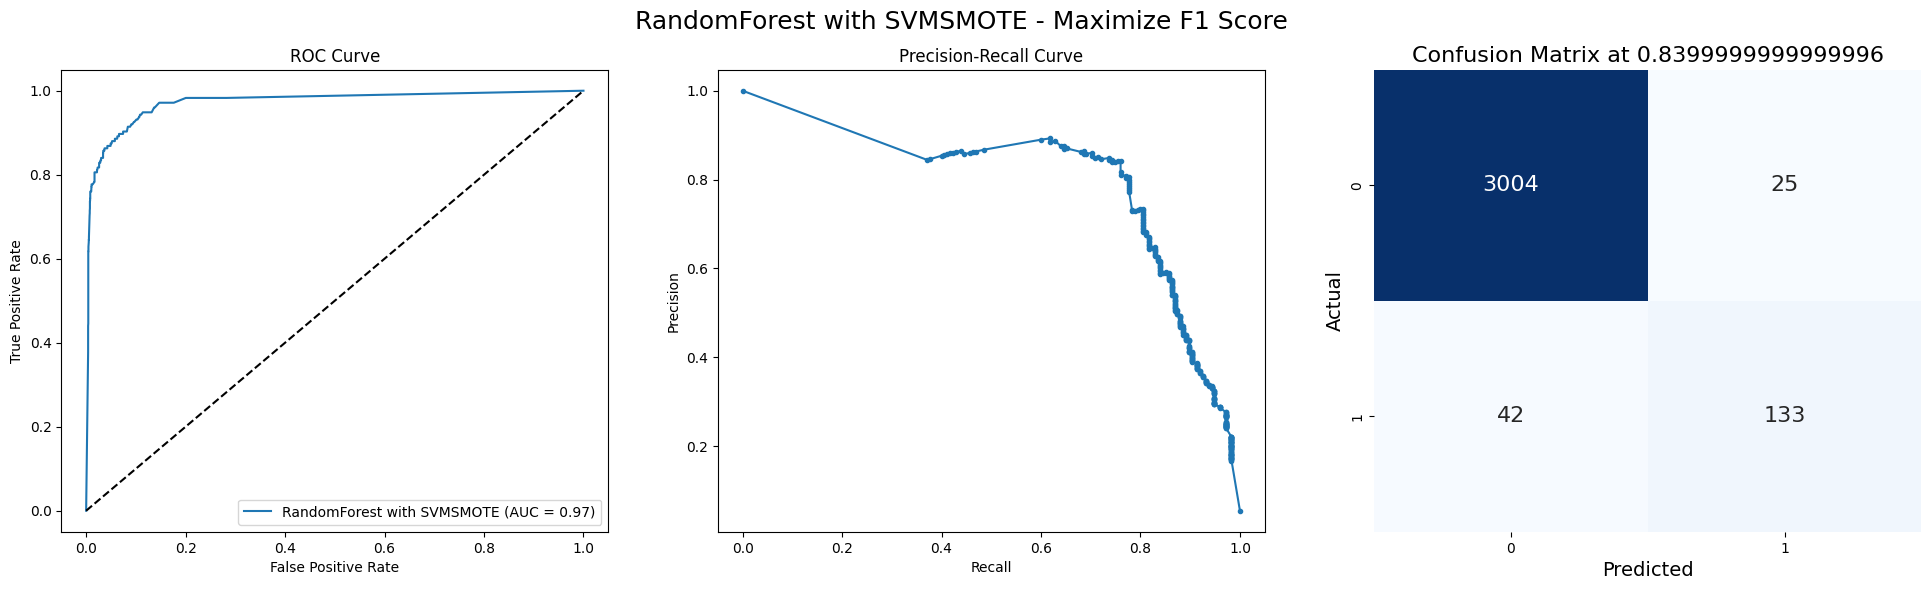

Best threshold by Recall for RandomForest with SVMSMOTE: 0.99


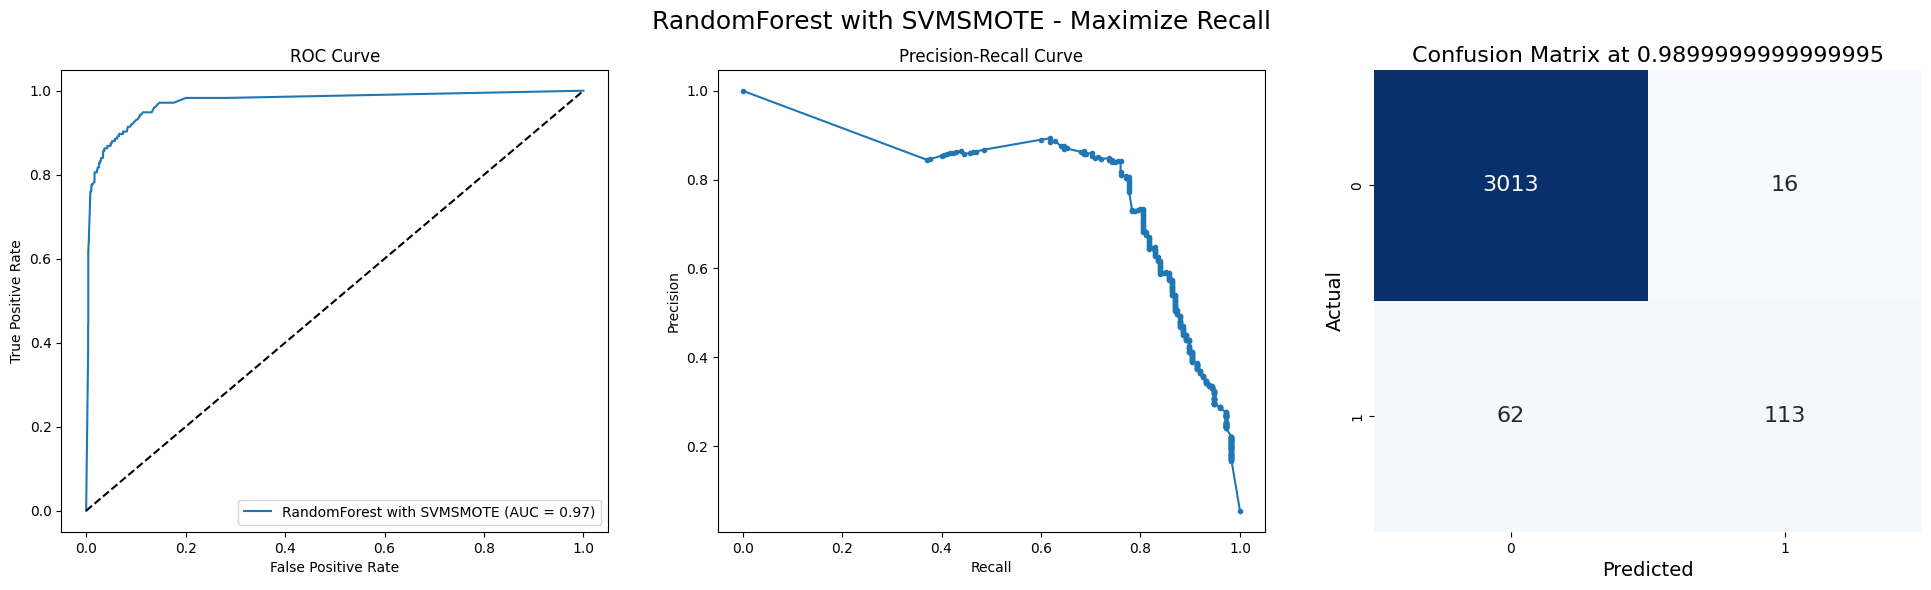


Evaluating GradientBoosting with SVMSMOTE...
Best threshold by F1 Score for GradientBoosting with SVMSMOTE: 0.85


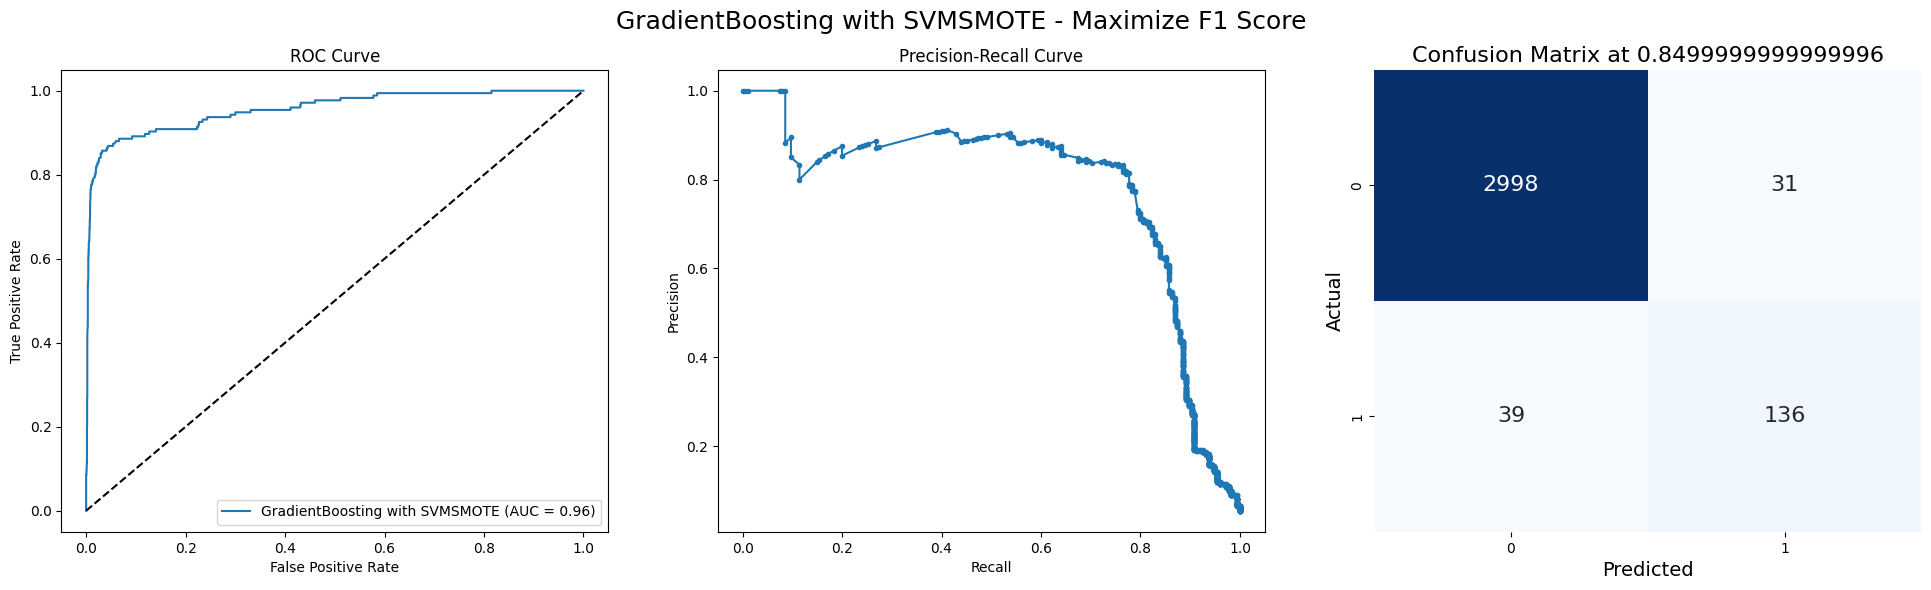

Best threshold by Recall for GradientBoosting with SVMSMOTE: 0.99


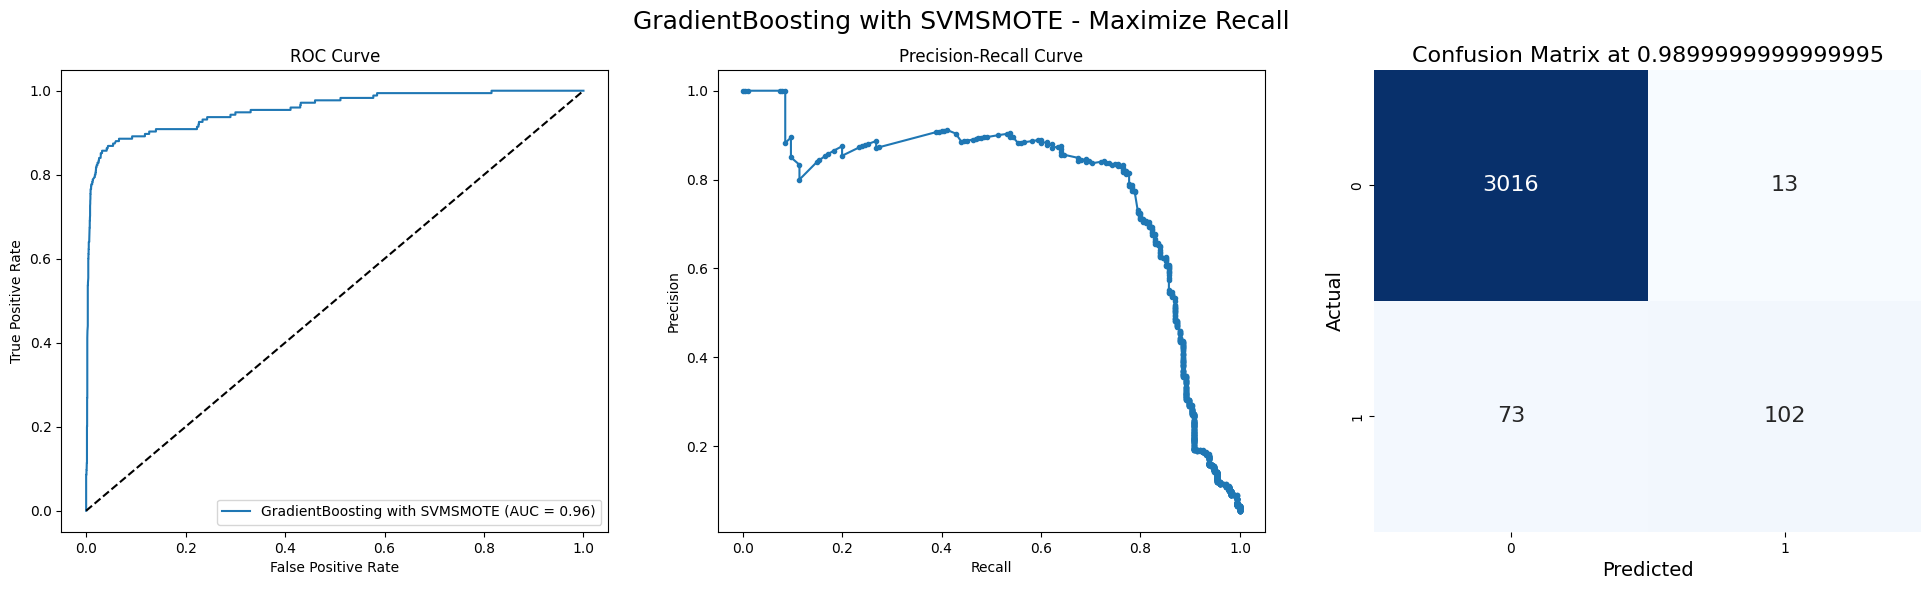


Evaluating AdaBoost with SVMSMOTE...
Best threshold by F1 Score for AdaBoost with SVMSMOTE: 0.50


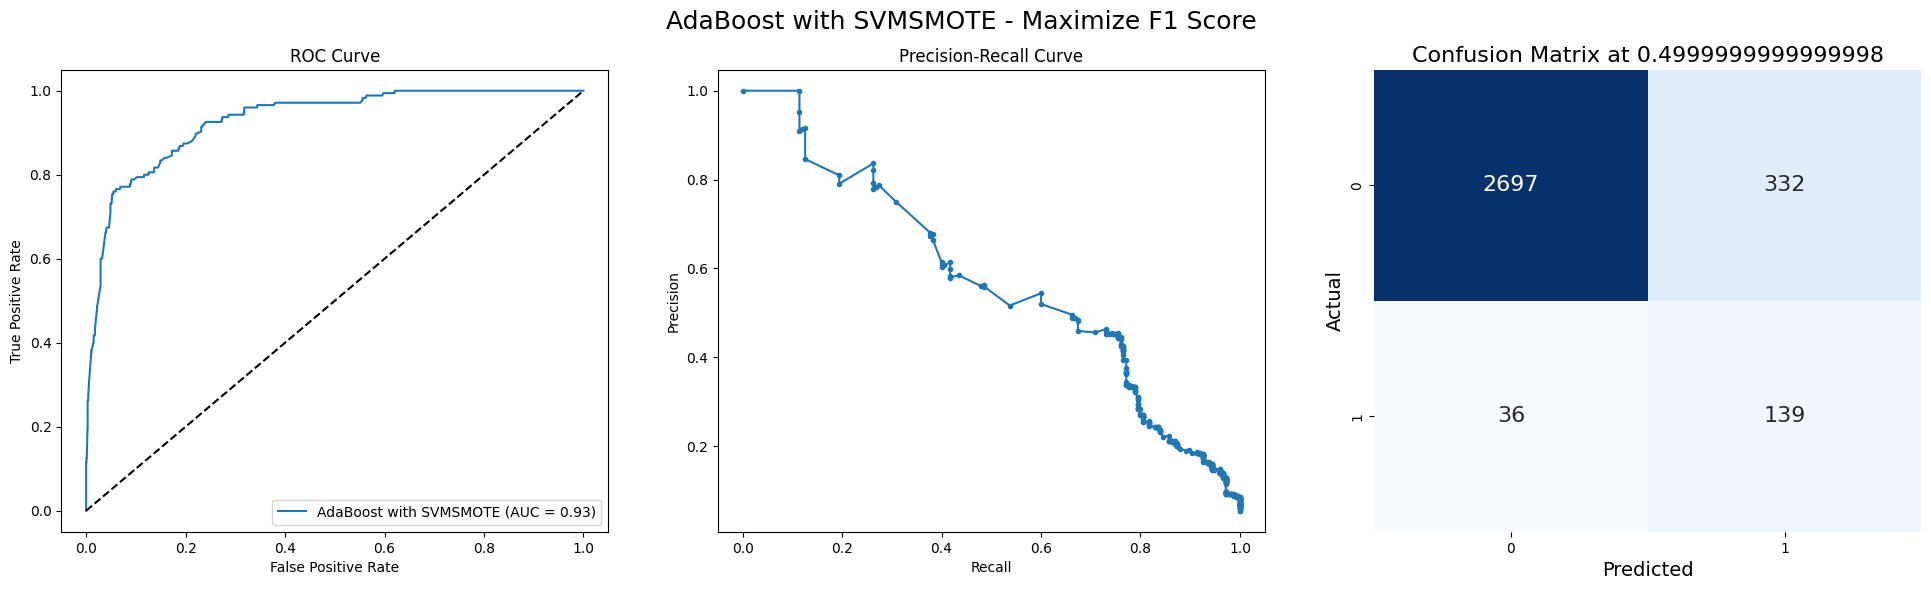

Best threshold by Recall for AdaBoost with SVMSMOTE: 0.51


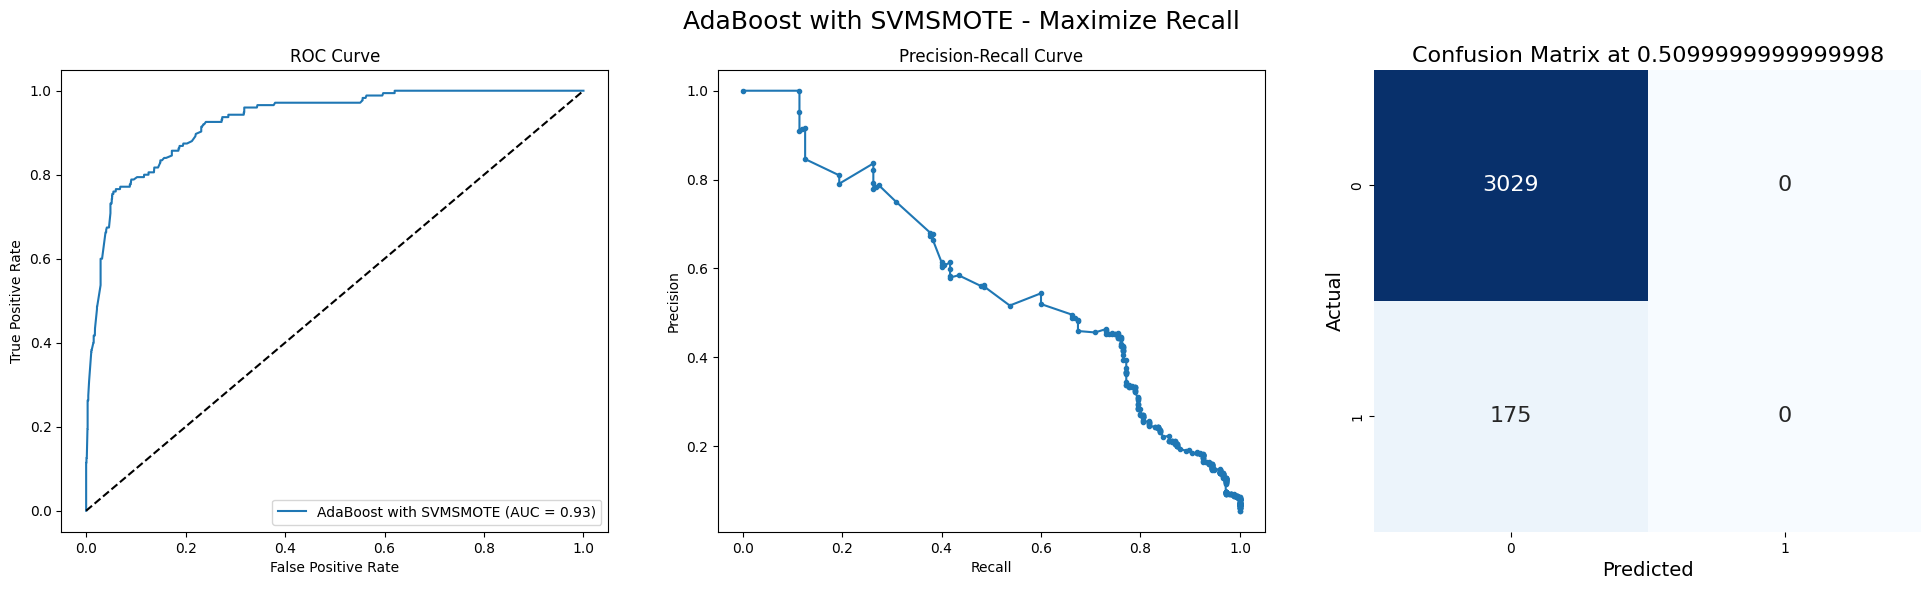

In [39]:


# Main evaluation loop
for resampling_name, models_dict in best_models.items():
    for model_name, best_model in models_dict.items():
        print(f"\nEvaluating {model_name} with {resampling_name}...")

        # Predict probabilities
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # Collect metrics for different thresholds
        metrics = []
        for threshold in np.arange(0.1, 1.0, 0.01):
            metric = evaluate_and_store_results(y_test, y_prob, threshold, resampling_name, model_name)
            metrics.append(metric)

        # Convert metrics to DataFrame for easy handling
        metrics_df = pd.DataFrame(metrics)

        # Strategy 1: Maximize F1 Score
        best_f1 = get_best_f1(metrics_df)
        print(f"Best threshold by F1 Score for {model_name} with {resampling_name}: {best_f1['threshold']:.2f}")
        generate_plots(y_test, y_prob, best_f1['threshold'], 'Maximize F1 Score', resampling_name, model_name)

        # Store the best F1 Score results
        best_threshold_results.append({
            'Resampling': resampling_name,
            'Model': model_name,
            'Strategy': 'Maximize F1 Score',
            'Threshold': best_f1['threshold'],
            'Precision': best_f1['precision'],
            'F1 Score': best_f1['f1'],
            'ROC AUC': best_f1['roc_auc'],
            'Sensitivity': best_f1['sensitivity'],
            'Specificity': best_f1['specificity']
        })

        # Strategy 2: Precision-Recall Trade-off
        best_recall = get_best_recall(metrics_df)
        print(f"Best threshold by Recall for {model_name} with {resampling_name}: {best_recall['threshold']:.2f}")
        generate_plots(y_test, y_prob, best_recall['threshold'], 'Maximize Recall', resampling_name, model_name)

        # Store the best Recall results
        best_threshold_results.append({
            'Resampling': resampling_name,
            'Model': model_name,
            'Strategy': 'Maximize Recall',
            'Threshold': best_recall['threshold'],
            'Precision': best_recall['precision'],
            'F1 Score': best_recall['f1'],
            'ROC AUC': best_recall['roc_auc'],
            'Sensitivity': best_recall['sensitivity'],
            'Specificity': best_recall['specificity']
        })

# Convert best results list to a DataFrame
best_threshold_results_df = pd.DataFrame(best_threshold_results)

In [40]:
best_threshold_results_df

Resampling             Model           Strategy  Threshold  \
0             SMOTE      RandomForest  Maximize F1 Score       0.89   
1             SMOTE      RandomForest    Maximize Recall       0.99   
2             SMOTE  GradientBoosting  Maximize F1 Score       0.83   
3             SMOTE  GradientBoosting    Maximize Recall       0.99   
4             SMOTE          AdaBoost  Maximize F1 Score       0.50   
5             SMOTE          AdaBoost    Maximize Recall       0.52   
6            ADASYN      RandomForest  Maximize F1 Score       0.88   
7            ADASYN      RandomForest    Maximize Recall       0.99   
8            ADASYN  GradientBoosting  Maximize F1 Score       0.88   
9            ADASYN  GradientBoosting    Maximize Recall       0.99   
10           ADASYN          AdaBoost  Maximize F1 Score       0.50   
11           ADASYN          AdaBoost    Maximize Recall       0.51   
12  BorderlineSMOTE      RandomForest  Maximize F1 Score       0.88   
13  BorderlineSMOTE      RandomForest    Maximize Recall       0.98   
14  BorderlineSMOTE  GradientBoosting  Maximize F1 Score       0.80   
15  BorderlineSMOTE  GradientBoosting    Maximize Recall       0.99   
16  BorderlineSMOTE          AdaBoost  Maximize F1 Score       0.50   
17  BorderlineSMOTE          AdaBoost    Maximize Recall       0.52   
18         SVMSMOTE      RandomForest  Maximize F1 Score       0.84   
19         SVMSMOTE      RandomForest    Maximize Recall       0.99   
20         SVMSMOTE  GradientBoosting  Maximize F1 Score       0.85   
21         SVMSMOTE  GradientBoosting    Maximize Recall       0.99   
22         SVMSMOTE          AdaBoost  Maximize F1 Score       0.50   
23         SVMSMOTE          AdaBoost    Maximize Recall       0.51   

    Precision  F1 Score   ROC AUC  Sensitivity  Specificity  
0    0.825806  0.775758  0.964398     0.731429     0.991086  
1    0.901639  0.740741  0.964398     0.628571     0.996038  
2    0.826347  0.807018  0.959355     0.788571     0.990426  
3    0.900000  0.611321  0.959355     0.462857     0.997029  
4    0.309735  0.446571  0.930809     0.800000     0.896996  
5    0.000000  0.000000  0.930809     0.000000     1.000000  
6    0.755556  0.766197  0.967474     0.777143     0.985474  
7    0.846939  0.608059  0.967474     0.474286     0.995048  
8    0.789474  0.780347  0.957991     0.771429     0.988115  
9    0.833333  0.155440  0.957991     0.085714     0.999010  
10   0.171913  0.283716  0.901737     0.811429     0.774183  
11   0.000000  0.000000  0.901737     0.000000     1.000000  
12   0.805195  0.753799  0.967770     0.708571     0.990096  
13   0.828571  0.621429  0.967770     0.497143     0.994057  
14   0.789157  0.768328  0.948314     0.748571     0.988445  
15   0.698113  0.324561  0.948314     0.211429     0.994718  
16   0.250831  0.388674  0.909695     0.862857     0.851106  
17   0.000000  0.000000  0.909695     0.000000     1.000000  
18   0.841772  0.798799  0.971933     0.760000     0.991746  
19   0.875969  0.743421  0.971933     0.645714     0.994718  
20   0.814371  0.795322  0.955494     0.777143     0.989766  
21   0.886957  0.703448  0.955494     0.582857     0.995708  
22   0.295117  0.430341  0.929180     0.794286     0.890393  
23   0.000000  0.000000  0.929180     0.000000     1.000000

#### 5.1.1 Model Performance By Tweaking The Decision Threshold (Bias)

When dealing with imbalanced datasets, selecting the best threshold (bias) involves balancing the trade-off between precision and Sensitivity. The goal is to find a threshold that optimizes the performance of the model for the specific use case. In this case the strategies is to select the best threshold:

- Maximize the F1 Score: The F1 score is the harmonic mean of precision and recall and is a good metric when you want to balance both.
- Precision-Recall Trade-off: Based on the use case,  we prioritize precision (minimizing false positives) or sensitivity (minimizing false negatives).

Based on this we tune the treshold of the resampled model between (0.1 - 1.0) priortizing on the twostrategies listed above.

The table above shows the result of the tuning of treshold.

Gradient Boosting with ADASYN (Maximize Recall) is the recommended model as it provides the best trade-off between high recall (sensitivity) and balanced precision, ensuring the model detects the majority of minority class instances while keeping false positives at a reasonable level. This model's high F1 score and ROC AUC demonstrate its robustness and ability to generalize well, making it suitable for the detection of the Common swift.

## Key Takeaway

- Without Resampling: High precision and specificity but low recall, making it less suitable for detecting all instances of the minority class.
- With Resampling: Significant improvement in recall but at the cost of precision, leading to more false positives.
-With Resampling and Tweaked Thresholds: Best balance of high recall and precision, maintaining a strong F1 score and ROC AUC. This approach ensures that the model detects the majority of minority class instances while keeping false positives manageable.


## Final Comments

If I were to spend four weeks on this, I will do the following:

- Create new features that could enhance the model's performance. This could include interaction features, polynomial features. I will also analyze the importance of existing features and remove any redundant or irrelevant features.

- I will additional data that might improve the model. This could involve external datasets or web scraping techniques.

- Experiment with various hyperparameter tuning methods, with a focus on Bayesian optimization, which can efficiently navigate the hyperparameter space.

- I will experiment on hybrid resampling methods that combine over-sampling and under-sampling to address class imbalance issues such as `Tomek-Link`, `Edited Nearest Neighbors`, e.t.c

- Experiment on more ensemble and tree based ML models